# Exploratory Data Analysis of Ames Housing Prices Dataset

<a id="sec_toc"></a>
# Table of Contents
* [Dataset Details](#sec_data_details)
* [Notebook Setup](#sec_setup)
* [Summarize Data Features](#sec_sum_features)
* [Data Cleaning](#sec_clean)
* [Feature Engineering](#sec_engineering)
* [Initial Visualization](#sec_visualize)
* [Feature Selection](#sec_selection)
* [Feature Transformation](#sec_transformation)
* [Model Building](#sec_model)
* [Post-mortem](#sec_post)
* [Appendix](#sec_appendix)

_NOTE_: The organization of steps in this notebook is non-linear. By this I mean that the justification for each step will not be obvious as one reads from top to bottom. It is organized so that the notebook runs smoothly and quickly. For example, if I get to the end model step and realize a way to improve things, I go back to previous steps, make changes, and re-run the notebook. Some justifications are preserved in the appendix and I intend to add to it later on.

<a id="sec_data_details"></a>
# Dataset Details
[top](#sec_toc)

This data set describes "the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values" ([De Cock 2011](http://jse.amstat.org/v19n3/decock.pdf))

### Feature Breakdown
* **SalePrice** - the property's sale price in dollars. This is the target variable that you're trying to predict.
* **Building classification**
    * MSSubClass: The building class
    * BldgType: Type of dwelling
    * HouseStyle: Style of dwelling
    * OverallQual: Overall material and finish quality
    * OverallCond: Overall condition rating
    * YearBuilt: Original construction date
    * YearRemodAdd: Remodel date
    * Functional: Home functionality rating
* **Land/Lot**
    * LotFrontage: Linear feet of street connected to property
    * LotArea: Lot size in square feet
    * LotShape: General shape of property
    * LandContour: Flatness of the property
    * LotConfig: Lot configuration
    * LandSlope: Slope of property
    * Foundation: Type of foundation
* **Surroundings**
    * MSZoning: The general zoning classification
    * Street: Type of road access
    * Alley: Type of alley access
    * Neighborhood: Physical locations within Ames city limits
    * Condition1: Proximity to main road or railroad
    * Condition2: Proximity to main road or railroad (if a second is present)
* **Exterior**
    * General
        * Exterior1st: Exterior covering on house
        * Exterior2nd: Exterior covering on house (if more than one material)
        * MasVnrType: Masonry veneer type
        * MasVnrArea: Masonry veneer area in square feet
        * ExterQual: Exterior material quality
        * ExterCond: Present condition of the material on the exterior
    * Roof
        * RoofStyle: Type of roof
        * RoofMatl: Roof material
    * Deck/Porch
        * WoodDeckSF: Wood deck area in square feet
        * OpenPorchSF: Open porch area in square feet
        * EnclosedPorch: Enclosed porch area in square feet
        * 3SsnPorch: Three season porch area in square feet
        * ScreenPorch: Screen porch area in square feet
    * Pool
        * PoolArea: Pool area in square feet
        * PoolQC: Pool quality
    * Fence: Fence quality
* **Basement**
    * BsmtQual: Height of the basement
    * BsmtCond: General condition of the basement
    * BsmtExposure: Walkout or garden level basement walls
    * BsmtFinType1: Quality of basement finished area
    * BsmtFinSF1: Type 1 finished square feet
    * BsmtFinType2: Quality of second finished area (if present)
    * BsmtFinSF2: Type 2 finished square feet
    * BsmtUnfSF: Unfinished square feet of basement area
    * TotalBsmtSF: Total square feet of basement area
    * BsmtFullBath: Basement full bathrooms
    * BsmtHalfBath: Basement half bathrooms
* **Above grade (i.e. above ground) interior**
    * 1stFlrSF: First Floor square feet
    * 2ndFlrSF: Second floor square feet
    * LowQualFinSF: Low quality finished square feet (all floors)
    * GrLivArea: Above grade (ground) living area square feet
    * FullBath: Full bathrooms above grade
    * HalfBath: Half baths above grade
    * BedroomAbvGr: Number of bedrooms above basement level
    * KitchenAbvGr: Number of kitchens
    * KitchenQual: Kitchen quality
    * TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
    * Fireplaces: Number of fireplaces
    * FireplaceQu: Fireplace quality
* **Garage**
    * GarageType: Garage location
    * GarageYrBlt: Year garage was built
    * GarageFinish: Interior finish of the garage
    * GarageCars: Size of garage in car capacity
    * GarageArea: Size of garage in square feet
    * GarageQual: Garage quality
    * GarageCond: Garage condition
    * PavedDrive: Paved driveway
* **Utilities**
    * Utilities: Type of utilities available
    * Heating: Type of heating
    * HeatingQC: Heating quality and condition
    * CentralAir: Central air conditioning
    * Electrical: Electrical system
* **Sale**
    * MoSold: Month Sold
    * YrSold: Year Sold
    * SaleType: Type of sale
    * SaleCondition: Condition of sale
    * MiscFeature: Miscellaneous feature not covered in other categories
    * MiscVal: Value of miscellaneous feature

For more detail on the data features, such as possible values for categorical features, see [data description](data/data_description.txt) file
 

<a id="sec_setup"></a>
# Notebook Setup
[top](#sec_toc)

In [3]:
# Imports
## Project
import utilities as util;

## 3rd-party
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    cross_val_score, train_test_split
)
from sklearn.feature_selection import (
    f_classif, mutual_info_classif,
    f_regression, mutual_info_regression,
    RFECV
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler, PowerTransformer,
    KBinsDiscretizer
)

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import pingouin as pg
import statsmodels.api as sm
import pandas as pd
from scipy import stats, optimize
import numpy as np

from IPython.display import display

## Built-in
from collections import defaultdict
import itertools
import os
import importlib
importlib.reload(util)

print('Directory Contents:')
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        if '/.' in dirname or '.pyc' in filename or '.swp' in filename: continue
        print('\t', os.path.join(dirname, filename))

/Users/alexarmstrong/anaconda3/envs/LexBase/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Directory Contents:
	 ./test_utilities.ipynb
	 ./AmesHousingEDA.ipynb
	 ./AmesHousingPriceRegression.ipynb
	 ./README.md
	 ./.gitignore
	 ./utilities.py
	 ./sample_submission.csv
	 ./images/FinalLinearFit.png
	 ./data/test.csv
	 ./data/data_description.txt
	 ./data/train.csv


In [4]:
# Load files
data_dir = './data'
df_train = pd.read_csv(f'{data_dir}/train.csv')
df_test = pd.read_csv(f'{data_dir}/test.csv')
target_var = 'SalePrice'
n = len(df_train) + len(df_test)

print(f'Train-Test split = {len(df_train)}:{len(df_test)} ({len(df_train)/n:.0%}:{len(df_test)/n:.0%})')

Train-Test split = 1460:1459 (50%:50%)


<a id="sec_sum_features"></a>
# Summarize Data Features
[top](#sec_toc)

In [5]:
target_val = 'SalePrice'

manual_type_set = {
    'Continuous' : [
       'LowQualFinSF',  # very few unique values 
       '3SsnPorch', 
       'PoolArea',
       'MiscVal',
    ],
    'Discrete' : [
        'Id',
        'BedroomAbvGr', # called 'Bedroom' in data_description.txt
        'KitchenAbvGr', # called 'Kitchen' in data_description.txt
        'Fireplaces',
        'MoSold',
        'YrSold',
        'YearBuilt',
        'GarageYrBlt',
        'YearRemodAdd',
        'GarageCars',
        'HalfBath',
        'FullBath',
        'BsmtHalfBath',
        'BsmtFullBath',
    ],
    'Ordinal' : [
        'OverallQual',
        'OverallCond',
        'ExterQual',
        'ExterCond',
        'PoolQC',
        'Fence',
        'BsmtFinType1',
        'BsmtFinType2',
        'BsmtQual',
        'BsmtCond',
        'BsmtExposure',
        'GarageQual',
        'GarageType', # maybe?
        'GarageFinish',
        'GarageCond',
        'KitchenQual',
        'FireplaceQu',
        'HeatingQC',
        'Electrical',
        'Functional',
        'PavedDrive',
    ]
    #'Nominal' : [
    #    
    #]
}
manual_type_set = {v:k  for k in manual_type_set for v in manual_type_set[k]}
data_types = util.categorize_data_type(df_train, override=manual_type_set)

In [6]:
df_features = data_types.to_frame('Data Subtype')
df_features['# Missing'] = df_train.isnull().sum()
df_features['% Missing'] = df_features['# Missing']/len(df_train)
df_features['# Unique']  = df_train.nunique()

# Quantify how balanced (i.e. evenly spread out) the data is
df_features['Entropy']      = [stats.entropy(df_train[c].value_counts()) for c in df_train]
df_features['Max Entropy']  = np.log(df_features['# Unique'])
df_features['Norm Entropy'] = df_features['Entropy']/df_features['Max Entropy']

# Variables to fill in for loop
df_features[[
             # Calculate the count ratio of the 1st and 2nd modes to identify unbalanced features
             'Mode', 'Mode Count', 'Mode %', 'Mode 2', 'Mode Ratio', 'Min Count',
             # Categorize as categorical or numerical
             'Data Type',
             # Correlations to target variable and the effect size
             'R2', 'pval', 
            ]] = np.nan

#num_cols = df_features.index[df_features['Data Subtype'].isin(['Continuous', 'Discrete'])].to_list()
for col in df_train:
    data = df_train[col]
    notnull = data.notnull()
    feature = df_features.loc[col,:].copy()
    x, y = data.loc[notnull], df_train.loc[notnull, target_var]
    x2d = pd.DataFrame(x, columns=[col])
    y2d = pd.DataFrame(y, columns=[target_var])
    
    # Mode
    vc = data.value_counts().sort_values(ascending=False)
    feature['Mode']       = vc.index[0]
    feature['Mode Count'] = vc.iloc[0]
    feature['Mode %']     = vc.iloc[0] / vc.sum()
    if len(vc) > 1:
        feature['Mode 2'] = vc.index[1]
        feature['Mode Ratio'] = vc.iloc[0]/vc.iloc[1]
    feature['Min Count'] = vc.iloc[-1] 

    # Data type specific
    dt = feature['Data Subtype']
    if dt in ['Continuous', 'Discrete']:
        feature['Data Type'] = 'Numerical'
        
        r, pval = stats.pearsonr(x, y)
        feature['R2'] = r**2
        feature['pval'] = pval * 100
        
    elif dt in ['Ordinal', 'Nominal']:
        feature['Data Type'] = 'Categorical'

        if feature['Min Count'] > 1:
            pval, n2 = pg.welch_anova(data=df_train, dv=target_var, between=col)[['p-unc', 'np2']].values[0]
            feature['R2'] = n2
            feature['pval'] = pval * 100
        
    else:
        feature['Data Type'] = 'Unknown'
    
    df_features.loc[col,:] = feature

# Show results
to_print = ['Data Subtype', '# Missing', '# Unique', 'Mode Ratio', 'Min Count', 'R2']
sort_by = ['Data Subtype', '# Missing', 'Norm Entropy']

with pd.option_context('display.max_rows', None, 
                       'display.max_columns', None):
    display(df_features.sort_values(by=sort_by, ascending=False)[to_print].round(2))

,Data Subtype,# Missing,# Unique,Mode Ratio,Min Count,R2
PoolQC,Ordinal,1453,3,1.50,2.0,0.58
Fence,Ordinal,1179,4,2.66,11.0,0.21
FireplaceQu,Ordinal,690,5,1.21,20.0,0.24
GarageFinish,Ordinal,81,3,1.43,352.0,0.27
GarageType,Ordinal,81,6,2.25,6.0,0.21
GarageQual,Ordinal,81,5,27.31,3.0,0.03
GarageCond,Ordinal,81,5,37.89,2.0,0.03
BsmtExposure,Ordinal,38,4,4.31,114.0,0.13
BsmtFinType2,Ordinal,38,6,23.26,14.0,0.01
BsmtFinType1,Ordinal,37,6,1.03,74.0,0.19


<a id="sec_clean"></a>
## Data Cleaning
[top](#sec_toc)

In [7]:
df_tmp = df_train.copy()

col_to_drop = []
num_cols = df_features.index[df_features['Data Type'] == 'Numerical']
cat_cols = df_features.index[df_features['Data Type'] == 'Categorical']

df_tmp.set_index('Id')
df_tmp.index.name = 'Id'

# Remove features with too many missing values
null_percent_cutoff = 0.40
#p_null = df_features['% Missing']
filt = df_features['% Missing'] > null_percent_cutoff
col_to_drop += df_features.loc[filt,'% Missing'].index.tolist()
print('Dropping columns based on null % >', null_percent_cutoff)
print(df_features.loc[col_to_drop,'% Missing'].sort_values(),'\n')

# Remove irrelevant features
#col_to_drop.append('Id')

# Remove colinear features
# col_to_drop += ['GrLivArea', 'TotalBsmtSF']

# Handle outliers and corrupt data
df_tmp.loc[df_tmp['GarageYrBlt'] > 2010, 'GarageYrBlt'] = np.nan # All dates beyond this are bugs (e.g. 2207)
df_tmp = df_tmp.drop(index=[1298, 523]) # Strange SF, largest total SF but very low price

# Impute missing values
num_strategy = 'mean'
cat_strategy = ['constant', 'Unknown']

n_before = df_tmp[num_cols].isnull().sum().sum()
imp_num = SimpleImputer(missing_values=np.nan, strategy=num_strategy)
imp_num.fit(df_tmp[num_cols])
df_tmp[num_cols] = imp_num.transform(df_tmp[num_cols])
n_after = df_tmp[num_cols].isnull().sum().sum()
print(f'Null values (numerical) before ({n_before}) and after ({n_after})')

n_before = df_tmp[cat_cols].isnull().sum().sum()
imp_cat = SimpleImputer(missing_values=np.nan, strategy=cat_strategy[0], fill_value=cat_strategy[1])
imp_cat.fit(df_tmp[cat_cols])
df_tmp[cat_cols] = imp_cat.transform(df_tmp[cat_cols])
n_after = df_tmp[cat_cols].isnull().sum().sum()
print(f'Null values (categorical) before ({n_before}) and after ({n_after})')

# Finalize cleaning
num_cols = num_cols.difference(col_to_drop + [df_tmp.index.name])
cat_cols = cat_cols.difference(col_to_drop + [df_tmp.index.name])
df_features = df_features.drop(col_to_drop, errors='ignore')
df_clean = df_tmp.drop(columns=col_to_drop + [df_tmp.index.name])

Dropping columns based on null % > 0.4
FireplaceQu    0.472603
Fence          0.807534
Alley          0.937671
MiscFeature    0.963014
PoolQC         0.995205
Name: % Missing, dtype: float64 

Null values (numerical) before (348) and after (0)
Null values (categorical) before (6610) and after (0)


<a id="sec_engineering"></a>
## Feature Engineering
[top](#sec_toc)

In [8]:
df_clean['TotalSF'] = df_clean['GrLivArea'] + df_clean['TotalBsmtSF']

#df_clean['Neighborhood_lon'] = 
#df_clean['Neighborhood_lat'] = 

for idx in df_clean.index:
    porch_type = []
    if df_clean.loc[idx, 'WoodDeckSF'] > 0:
        porch_type.append('Wood')
    if df_clean.loc[idx, 'OpenPorchSF'] > 0:
        porch_type.append('Open')
    if df_clean.loc[idx, 'EnclosedPorch'] > 0:
        porch_type.append('Enclosed')
    if df_clean.loc[idx, 'ScreenPorch'] > 0:
        porch_type.append('Screen')
    if df_clean.loc[idx, '3SsnPorch'] > 0:
        porch_type.append('3Ssn')
    
    df_clean.loc[idx,'nPorches'] = len(porch_type)
    
    porch_type = "_".join(porch_type) if porch_type else 'No Porch'
    df_clean.loc[idx,'PorchType'] = porch_type

# Combine
# GarageCars -> 0, 1, 2, 3+

num_cols = num_cols.union(pd.Index(['TotalSF', 'nPorches']))
cat_cols = cat_cols.union(pd.Index(['PorchType']))

<a id="sec_visualize"></a>
## Initial Visualization
[top](#sec_toc)

In [9]:
def bin_num_corr_plots():
    # t-test
    # Point biserial correlation
    # Logistic regression correlation
    # general cat_num correlation measures
    pass

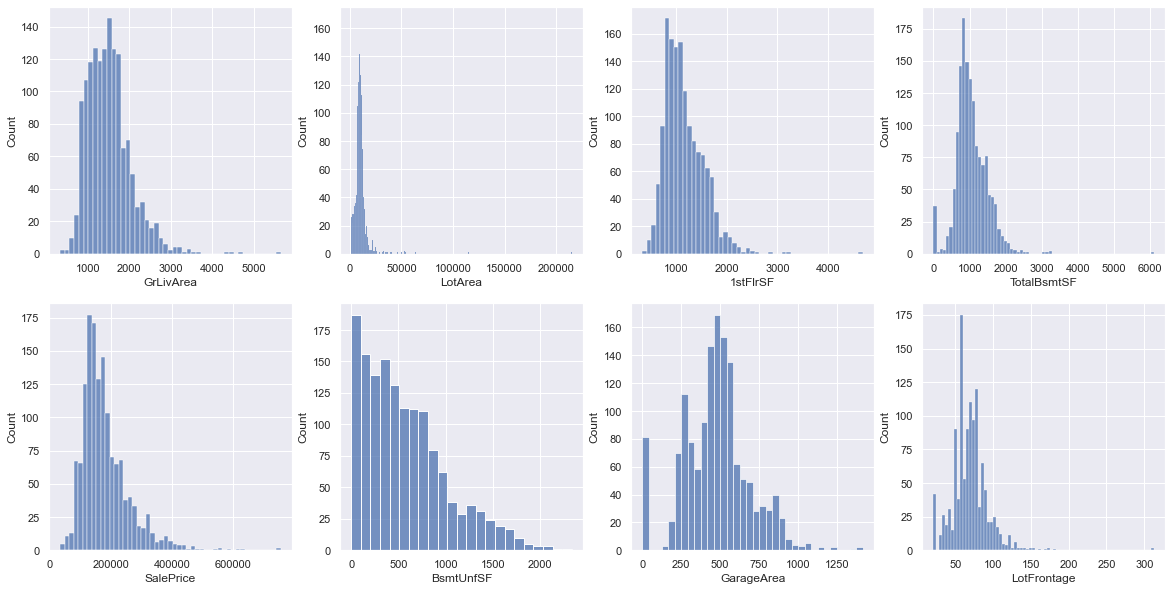

In [10]:
filt = (df_features["Data Subtype"] == 'Continuous') & (df_features["Mode Ratio"] <= 15)
cols = df_features.loc[filt,:].sort_values('Norm Entropy', ascending=False).index
fig, axs = util.plot_grid(df_train, cols, plottype = 'histplot')

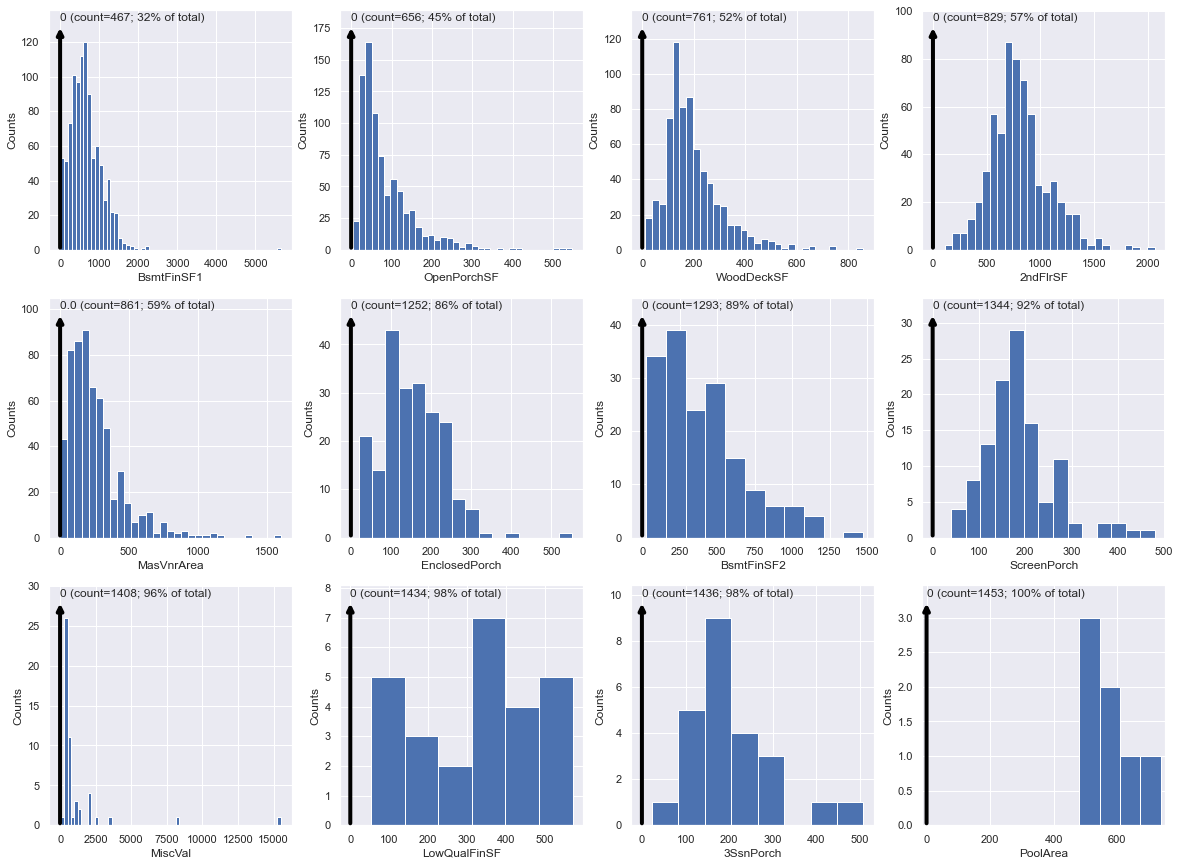

In [11]:
filt = (df_features["Data Subtype"] == 'Continuous') & (df_features["Mode Ratio"] > 15)
cols = df_features.loc[filt,:].sort_values('Norm Entropy', ascending=False).index
fig, axs = util.plot_grid(df_train, cols, plottype = 'histplot_crop')

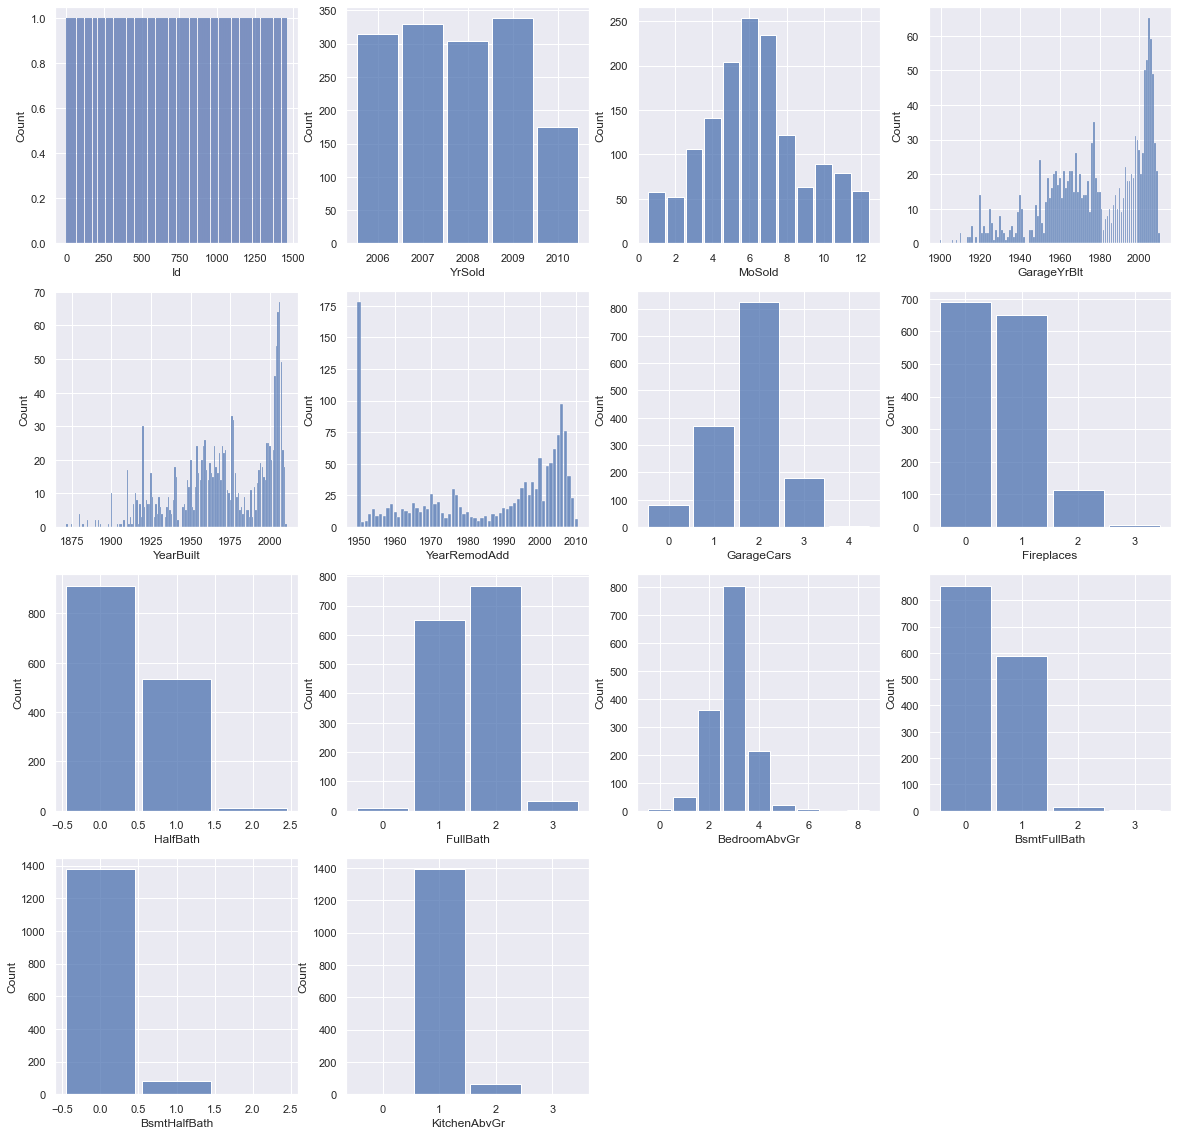

In [12]:
filt = (df_features["Data Subtype"] == 'Discrete')
cols = df_features.loc[filt,:].sort_values('Norm Entropy', ascending=False).index
fig, axs = util.plot_grid(df_train, cols, plottype = 'histplot_discrete')

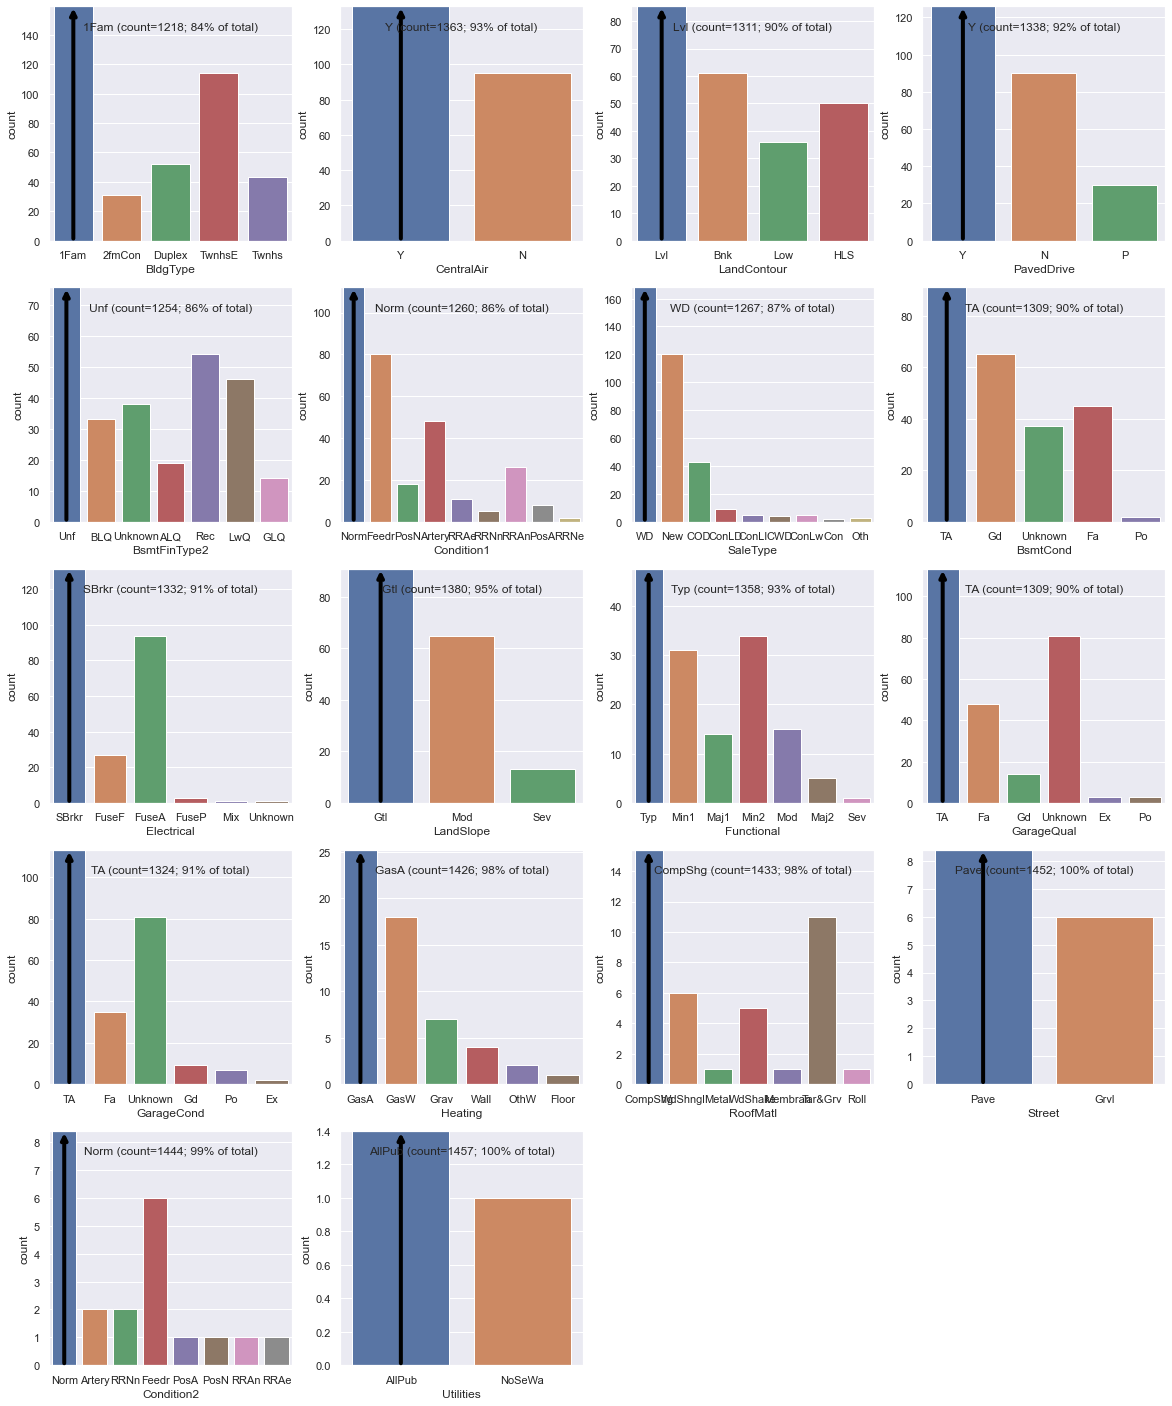

In [13]:
filt = (df_features["Data Type"] == 'Categorical') & (df_features["Mode Ratio"] > 10)
cols = df_features.loc[filt,:].sort_values('Norm Entropy', ascending=False).index
fig, axs = util.plot_grid(df_clean, cols, plottype='countplot_crop')

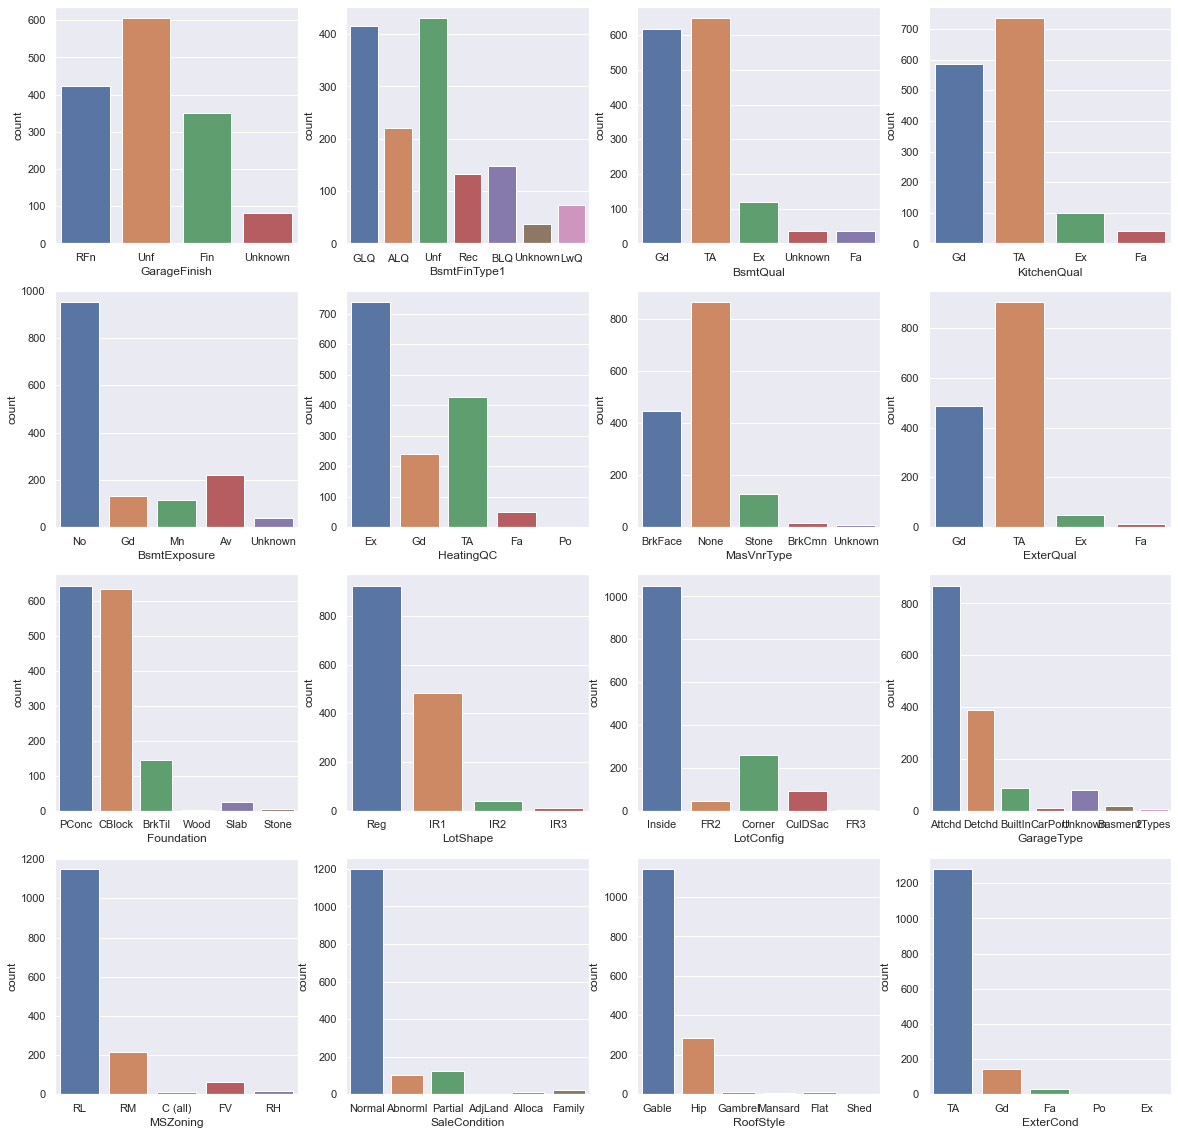

In [14]:
filt = ((df_features["Data Type"] == 'Categorical') 
     & (df_features["Mode Ratio"] <= 10)
     & (df_features["# Unique"] <= 6))
cols = df_features.loc[filt,:].sort_values('Norm Entropy', ascending=False).index
fig, axs = util.plot_grid(df_clean, cols, plottype='countplot_few')

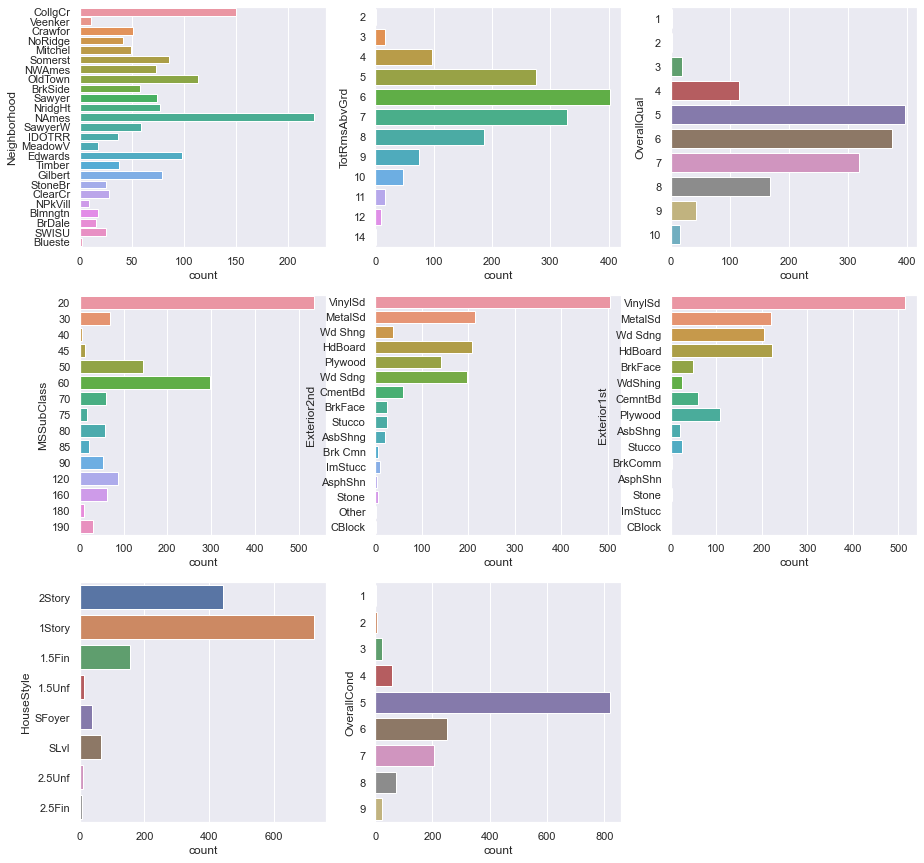

In [15]:
filt = ((df_features["Data Type"] == 'Categorical') 
     & (df_features["Mode Ratio"] <= 10)
     & (df_features["# Unique"] > 6))
cols = df_features.loc[filt,:].sort_values('Norm Entropy', ascending=False).index
fig, axs = util.plot_grid(df_clean, cols, plottype='countplot_many', ncols=3)

In [16]:
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence

def get_outlier_idx(df):
    # Internally studentized residuals : >3   (maybe), >4 (likely)
    # Externally studentized residuals : >3   (maybe), >4 (likely)
    #                           DFFITS : >2   (maybe), >3 (likely)
    #                         Cook's D : >0.5 (maybe), >1 (likely) 
    #        MAD standardized residual : >5   (maybe), >8 (likely)
    p = 1 # num of parameters
    dffits_scale = np.sqrt((p+1)/(len(x)-p-1))
    mask = ((df['standard_resid'] > 3) #
          | (df['student_resid']  > 3)
          | (df['dffits']         > 2 * dffits_scale)
          | (df['cooks_d']        > 0.5)
          #| (df['mad_resid']      > 4)
    )
    return mask

def num_num_corr_plots(df, feature1, feature2, trim=5, loess_frac=1/3, x_jitter=0, maxfev=None):
    """
    Plot and quantify correlations between two numerical variables
    """
    # TODO : Fix color of Data markers in legend for scatter plots using Cook's D cmap
    ########################################
    # Extract variables
    filt = df[feature1].notnull()
    x, y = df.loc[filt,feature1], df.loc[filt, feature2]
    x2d = pd.DataFrame(x)
    
    # Perform OLS regression
    model = sm.OLS(y, sm.add_constant(x2d))
    result = model.fit()
    residual = y.values - result.predict(sm.add_constant(x2d))
    
    # Calculate influence to help detect outliers
    influence = OLSInfluence(result)
    df_influence = influence.summary_frame()
    m_ts, b_ts, m_ts_lo, m_ts_hi = stats.theilslopes(y, x)
    y_pred_ts = m_ts * x + b_ts
    median_resid = y - y_pred_ts
    mad = stats.median_abs_deviation(median_resid)
    df_influence['mad_resid'] = median_resid/mad
    mask = get_outlier_idx(df_influence)
    df_influence['abs_dffits'] = df_influence.dffits.abs()
    outlier_mask = df_influence.sort_values('abs_dffits', ascending=False).index[:5] 
    
    ########################################
    # Prepare figure
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    
    ########################################
    # Visualize relationship with scatter plot (check for linearity)
    ax = axs[0,0]
    # Scatter plot
    x_jitter = x + stats.uniform.rvs(size=len(x), loc=-x_jitter, scale=2*x_jitter)
    #c_scale = df_influence['abs_dffits'].max()+1 - df_influence['abs_dffits']
    c_scale = df_influence['cooks_d'].max()+1 - df_influence['cooks_d']
    ax.scatter(x_jitter, y, label="Data (hue = Cook's D)", c=c_scale, cmap='copper')
    x_ref = np.linspace(min(x), max(x), 100)
    y_pred = result.predict(sm.add_constant(x_ref.reshape(-1,1)))
    
    # Linear fit
    ax.plot(x_ref, y_pred, 'k', lw=3, label='Linear Fit')
    
    # Robust median linear fit
    y_pred = m_ts*x_ref + b_ts
    ax.plot(x_ref, y_pred, 'g--', lw=2, label='Theil-Sen Fit')
    #m_sg, b_sg = stats.siegelslopes(y, x)
    #y_pred_sg = m_sg * x_ref + b_sg
    #ax.plot(x_ref, y_pred_sg, 'g--', lw=2, label='Siegel Fit')
    
    # LOWESS fit
    with np.errstate(invalid='ignore'):
        # Avoid smoothers_lowess.py: invalid value encountered in true_divide
        # Occurs with discrete data because of relatively large gaps
        lowess = sm.nonparametric.lowess(y, x, frac=loess_frac)
    ax.plot(lowess[:,0], lowess[:,1], 'c--', lw=2, label='LOWESS Fit')
    
    # Power transform of x
    popt = util.power_fit(x.to_numpy(), y, maxfev=maxfev)
    a,s,p,b = popt
    y_power = a*(x_ref-s)**p + b
    ax.plot(x_ref, y_power, 'r--', lw=2, label='Power Fit')
    
    # Finalize plot
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.legend()
    xlo, xhi = ax.get_xlim()
    diff = xhi-xlo
    xlo, xhi = xlo - 0.05*diff, xhi + 0.05*diff
    ax.set_xlim(xlo, xhi)
    
    ########################################
    # Visualize residuals to check linearity and homoskedasticity
    ax = axs[1,0]
    p_data = ax.scatter(x_jitter, residual, label='Residuals', c=c_scale, cmap='copper')
    ax.axhline(0, ls=':', c='k')
    #x_ref, ymid, ylo, yhi = util.local_sigma_bands(x, residual, window_scale=10, percentiles=True)
    x_ref, ymid, ylo, yhi = util.local_sigma_bands(x.to_numpy(), residual.to_numpy(), window_scale=1/3)
    p_mean, = ax.plot(x_ref, ymid, 'k--', alpha=0.7)
    p_sigma = ax.fill_between(x_ref, yhi, ylo, color='k', alpha=0.3)
    ax.set_xlabel(feature1)
    ax.set_ylabel(f'{feature2} Residual')
    ax.set_xlim(xlo, xhi)
    ax.legend([p_data, (p_mean,p_sigma)], ["Data (hue = Cook's D)", 'Local $\mu\pm\sigma$'])
    
    ########################################
    # Visualize residuals to check normality
    ax = axs[0,1]
    sns.histplot(residual, kde=True, stat='density', label='Data w/ KDE', ax=ax)
    mean, std = np.mean(residual), np.std(residual)
    lo, hi = np.percentile(residual, [trim/2,100-trim/2])
    diff = hi - lo
    xmin, xmax = lo - diff/2, hi + diff/2
    mean_trim, std_trim = stats.tmean(residual, (lo, hi)), stats.tstd(residual, (lo, hi))
    x_ref = np.linspace(xmin, xmax, 1000)
    norm_ref = stats.norm(loc=mean, scale=std).pdf(x_ref)
    norm_ref_trim = stats.norm(loc=mean_trim, scale=std_trim).pdf(x_ref)
    ax.plot(x_ref, norm_ref, 'r', label='Normal Fit')
    ax.plot(x_ref, norm_ref_trim, 'r--', label='Trimmed Normal Fit')
    ax.axvline(lo, c='k', ls=':', label='Trim Edges')
    ax.axvline(hi, c='k', ls=':')
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('Residual')
    ax.legend()
    
    # Visualize residuals to check normality
    ax = axs[1,1]
    lo, hi = np.percentile(residual, [trim/2,100-trim/2])
    res_trim = residual[(lo <= residual) & (residual <= hi)]
    sm.qqplot(res_trim, ax=ax, markerfacecolor='c')
    sm.qqplot(residual, line='s', ax=ax, markerfacecolor='b')
    h_trim = ax.axhline(lo, c='k', ls=':')
    ax.axhline(hi, c='k', ls=':')
    _, pval = stats.normaltest(residual)
    ax.annotate(f'Normal Test : p-val = {pval:.2%}', size='x-large',
                xy=(0.5,0.9), xycoords='axes fraction', ha='center')
    _, pval = stats.normaltest(res_trim)
    ax.annotate(f'(Trim {trim}% : p-val = {pval:.2%})', size='large',
                xy=(0.5,0.8), xycoords='axes fraction', ha='center')
    ymin, ymax = ax.get_ylim()
    height = ymax - ymin
    ax.set_ylim(ymin, ymax+height/5)
    h_data = Line2D([0],[0], color='b', lw=0, marker='o')
    h_data_trim = Line2D([0],[0], color='c', lw=0, marker='o')
    h_normal = Line2D([0],[0], color='r')
    ax.legend([h_data, h_data_trim, h_trim, h_normal], 
              ['Data', 'Data (trimmed)', 'Trim Edges', 'Normal Ref'], 
              loc='lower right')

     ## Determine dependency of normality pval on outliers
     #pvals = []
     #percentiles = np.linspace(0,20,100)
     #for p in percentiles:
     #    lo, hi = np.percentile(residual, [p/2, 100-p/2])
     #    res_trim = residual[(lo <= residual) & (residual <= hi)]
     #    _, pval = stats.normaltest(res_trim)
     #    pvals.append(pval)
     #ax.plot(percentiles, pvals, 'bo')
     #ax.set_xlabel('Edge Percentile Trim')
     #ax.set_ylabel('p-value')
     #print(percentiles[np.argmax(pvals)])

    ########################################
    # (TODO) Visualize residuals to check autocorrelation

    plt.show()
    ########################################
    # Quantify correlation, significance, and residual behavior
    print('Correlation Measures:')
    m, m_unc, m_pval = result.params[1], result.bse[1], result.pvalues[1]
    pr, pr_pval = stats.pearsonr(x, y)
    sr, sr_pval = stats.spearmanr(x, y)
    #pr, pr_pval, r2, bf10 = pg.corr(x, y, method='pearson')[['r','p-val','r2','BF10']].values[0]
    mi = mutual_info_regression(x.to_frame(), y)[0]
    a,s,p,b = popt
    # kendall's tau
    # Goodman-Krustall’s gamma
    # (TODO) Permutation test (model_selection.permutation_test_score)
    print(f"\t      OLS Fit Slope = {m:.2f} +/- {m_unc:.2f} (pval = {m_pval:.1%})")
    print(f"\t        Pearson's r = {pr:.2f} (pval = {pr_pval:.1%}; R2 = {pr**2:.2f})")
    print(f"\t    Theil-Sen Slope = {m_ts:.2f} (95% CI = [{m_ts_lo:.2f},{m_ts_hi:.2f}])")
    #print(f"\t       Siegel Slope = {m_sg:.2f}")
    print(f"\t       Spearman's r = {sr:.2f} (pval = {sr_pval:.1%})")
    print(f"\t          Power fit = {a:.2e} (x - {s:.2e})^{p:.2f} + {b:.2e}")
    print(f"\t Mutual information = {mi:.3f}")
    
    print("\nHomoscedasticity Tests on Residuals: ")
    br_pval = sms.diagnostic.het_breuschpagan(residual, x.to_frame())[3]
    print(f"\t Breusch-Pagan p-value = {br_pval:.1%}")
    
    print("\nNormality Tests on Residuals : ")
    #print(f"\t      Shapiro-Wilk p-value = {stats.shapiro(residual)[1]:.1%}")
    #print(f"\t       Jarque-Bera p-value = {stats.jarque_bera(residual)[1]:.1%}")
    print(f"\tD'Agostino-Pearson p-value = {stats.normaltest(residual)[1]:.1%}")
    print(f"\t   Normal Kurtosis p-value = {stats.kurtosistest(residual)[1]:.1%}")
    print(f"\t       Normal Skew p-value = {stats.skewtest(residual)[1]:.1%}")
    
    #print("\nLinearity Tests : ") # Large FPR for my use cases so far
    #rb_pval = sms.linear_rainbow(result, frac=0.5)[1]
    #hc_pval = sm_diagnostic.linear_harvey_collier(result)[1]
    #print(f"\t       Rainbow = {rb_pval:.1%}")
    #print(f"\tHarvey Collier = {hc_pval:.1%}")
    
    #print("\nAutocorrelation Tests on Residuals : ")
    #print(f"\tDurbin-Watson = {sms.stattools.durbin_watson(residual):.1f}")
    

    df_influence[feature1] = x
    df_influence[feature2] = y
    df_influence['abs_dffits'] = df_influence.dffits.abs()
    col_to_show = [feature1, feature2, 'mad_resid', 'hat_diag', 'standard_resid', 'cooks_d', 'student_resid', 'dffits']
    n_rows = 10
    print(f"\nOutlier Scores : Top {n_rows} from {mask.sum()}/{len(df_influence)} flagged features")
    display(df_influence[mask].sort_values('abs_dffits', ascending=False)[col_to_show].iloc[:n_rows])
    
    return fig, axs

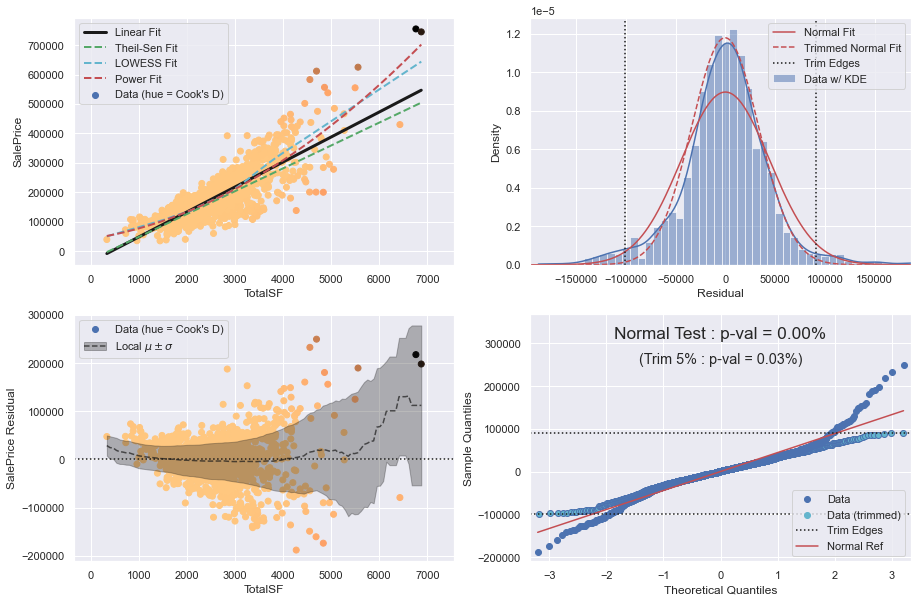

Correlation Measures:
	      OLS Fit Slope = 84.91 +/- 1.50 (pval = 0.0%)
	        Pearson's r = 0.83 (pval = 0.0%; R2 = 0.69)
	    Theil-Sen Slope = 77.70 (95% CI = [74.56,80.83])
	       Spearman's r = 0.82 (pval = 0.0%)
	          Power fit = 1.78e-02 (x - -1.03e+03)^1.94 + 2.92e+04
	 Mutual information = 0.669

Homoscedasticity Tests on Residuals: 
	 Breusch-Pagan p-value = 0.0%

Normality Tests on Residuals : 
	D'Agostino-Pearson p-value = 0.0%
	   Normal Kurtosis p-value = 0.0%
	       Normal Skew p-value = 0.1%

Outlier Scores : Top 10 from 60/1458 flagged features


,TotalSF,SalePrice,mad_resid,hat_diag,standard_resid,cooks_d,student_resid,dffits
Id,,,,,,,,
691,6760.0,755000.0,12.005987,0.020753,4.947440,0.259370,4.987844,0.726118
1182,6872.0,745000.0,11.139640,0.021838,4.506575,0.226710,4.536779,0.677878
1169,5557.0,625000.0,10.313857,0.010898,4.292875,0.101524,4.318819,0.453331
898,4694.0,611657.0,12.801910,0.005859,5.633730,0.093531,5.694200,0.437149
803,4556.0,582933.0,11.968017,0.005211,5.248445,0.072146,5.296988,0.383372
1046,4860.0,556581.0,9.653140,0.006697,4.075344,0.055985,4.097381,0.336429
769,4929.0,538000.0,8.544062,0.007063,3.524542,0.044183,3.538458,0.298437
440,5496.0,555000.0,7.290787,0.010486,2.826581,0.042333,2.833395,0.291676
178,4450.0,501837.0,8.592912,0.004742,3.622050,0.031256,3.637229,0.251073


In [38]:
num_num_corr_plots(df_clean, 'TotalSF', target_var)
#num_num_corr_plots(df_clean, 'BsmtUnfSF', target_var)
#num_num_corr_plots(df_clean, 'OverallQual', target_var, loess_frac=4/5, x_jitter=.2)
#num_num_corr_plots(df_clean, 'KitchenAbvGr', target_var, loess_frac=4/5, x_jitter=.3)
plt.show()

In [18]:
util.outlier_check(df_train, index=313, num_features=num_cols, print_result=True)
#util.outlier_check(df_train, index=335, num_features=num_cols, print_result=True)
#util.outlier_check(df_train, index=249, num_features=num_cols, print_result=True)

Outlier test for entry 313
Numerical Outliers


,Value,Mean,Median,NN value,|Z-score|,percentile-score,|MAD-score|
LotArea,215245.0,10516.828082,9478.5,164660.0,20.518273,100.000000,102.986236
BsmtFinSF2,820.0,46.549315,0.0,823.0,4.796176,98.904110,inf
TotalBsmtSF,2136.0,1057.429452,991.5,2136.0,2.459373,98.869863,4.880597
SalePrice,375000.0,180921.195890,163000.0,374000.0,2.443847,97.054795,5.578947
1stFlrSF,2036.0,1162.626712,1087.0,2042.0,2.259959,97.602740,4.046908
BsmtFinSF1,1236.0,443.639726,383.5,1237.0,1.737854,94.178082,2.222947
BsmtUnfSF,80.0,567.240411,477.5,80.0,1.103064,67.808219,1.380208
GrLivArea,2036.0,1515.463699,1464.0,2035.0,0.990931,78.424658,1.754601
YearRemodAdd,1965.0,1984.865753,1994.0,1965.0,0.962566,76.780822,2.230769
2ndFlrSF,0.0,346.992466,0.0,0.0,0.795163,28.424658,0.000000


Categorical Outliers


,Value,Mode,freq,freq rank,# unique,rel freq,cum freq,max freq ratio,NN freq ratio
LotShape,IR3,Reg,10.0,4.0,4.0,0.006849,0.006849,0.010811,0.243902
LandSlope,Sev,Gtl,13.0,3.0,3.0,0.008904,0.008904,0.009407,0.200000
BsmtFullBath,2,0,15.0,3.0,4.0,0.010274,0.010959,0.017523,0.025510
Heating,GasW,GasA,18.0,2.0,6.0,0.012329,0.021918,0.012605,0.012605
LandContour,Low,Lvl,36.0,4.0,4.0,0.024658,0.024658,0.027460,0.720000
Exterior2nd,BrkFace,VinylSd,25.0,9.0,16.0,0.017123,0.049315,0.049603,0.961538
Fireplaces,2,0,115.0,3.0,4.0,0.078767,0.082192,0.166667,0.176923
Exterior1st,BrkFace,VinylSd,50.0,7.0,15.0,0.034247,0.087671,0.097087,0.819672
BsmtFinType2,Rec,Unf,54.0,2.0,6.0,0.036986,0.113699,0.042994,0.042994
Neighborhood,Timber,NAmes,38.0,15.0,25.0,0.026027,0.154110,0.168889,0.926829


In [19]:
def cat_num_corr_plots(df, cat_feature, num_feature, rare_thr=1, groups=None):
    n_show_pairtests = 10

    df = df[[cat_feature, num_feature]].dropna()
    
    if groups:
        for grp_label, grp_vals in groups.items():
            df[cat_feature] = df.where(~df[cat_feature].isin(grp_vals), grp_label)
        
    vc = df[cat_feature].value_counts()
    min_count = vc.min()
    rare_vals = vc.index[vc <= rare_thr]
    if len(rare_vals) > 1:
        df[cat_feature] = df.where(~df[cat_feature].isin(rare_vals), 'Other')
        print(f"Grouping under 'Other' (Cutoff count = {rare_thr})")
        buff = len(max(rare_vals.astype('str'))) + 1
        for c in rare_vals: print(f'\t{c:>{buff}} (count = {vc[c]})')
            
        vc = df[cat_feature].value_counts()
        min_count = vc.min()
    
    if min_count == 1:
        print("WARNING : Group with 1 entry prevents full analysis, consider regrouping or dropping entry")
    
    df_grp = df.groupby(cat_feature)[num_feature]
    sorted_index = df_grp.mean().sort_values().index
    
    shapiro    = lambda x : np.round(stats.shapiro(x)[1],3)      if len(x) > 2   else np.nan
    jarque     = lambda x : np.round(stats.jarque_bera(x)[1],3)  if len(x) > 2   and np.var(x) > 0 else np.nan
    dagostino  = lambda x : np.round(stats.normaltest(x)[1],3)   if len(x) >= 20 else np.nan
    skew       = lambda x : np.round(stats.skewtest(x)[1],3)     if len(x) > 8   else np.nan
    kurtosis   = lambda x : np.round(stats.kurtosistest(x)[1],3) if len(x) >= 20 else np.nan
    #p_outliers = lambda x : pg.madmedianrule(x).sum()/len(x)     if len(x) > 3   else np.nan
    agg_funcs = ['count', 'mean', 'median', 'std', 
                 skew, kurtosis, jarque, 
                 #p_outliers
                ]
    df_tests = df_grp.agg(agg_funcs).rename(
    columns={
             '<lambda_0>':'Normal Skew pval',
             '<lambda_1>':'Normal Kurtosis pval',
             '<lambda_2>':'Normality (Jarque-Bera) pval',
             #'<lambda_3>':'% MAD-median outliers', 
            },
    )
    df_tests = df_tests.loc[sorted_index]
    
    min_std = df_tests['std'].min()
    if min_std == 0:
        print("WARNING : Group with variance = 0 prevents full analysis, consider regrouping or dropping entries")
    ########################################
    fig, axs = plt.subplots(2,2,figsize=(15,10))

    # Count plot to visualize balance
    ax = axs[0,1]
    ax.set_title("Data balance")
    sns.countplot(data=df, y=cat_feature, order=sorted_index, ax=ax)

    # Boxplot to visualize correlation with target
    ax = axs[0,0]
    ax.set_title("Target correlation")
    sns.stripplot(data=df, y=cat_feature, x=num_feature, 
                  orient='h', order=sorted_index,
                  jitter=True, size=3, color=".3", linewidth=0,
                  ax=ax)
    #whis = np.inf if min_count > 1 else 1.5 # prevent warning
    sns.boxplot(data=df, y=cat_feature, x=num_feature, 
                orient='h', whis=1.5, fliersize=0, order=sorted_index, 
                ax=ax)

    # Studentized residual plot to visualize normality and outliers
    ax = axs[1,0]
    ax.set_title("Normality and outlier check")
    resids = pd.DataFrame(df[cat_feature], columns=[cat_feature])
    resids['Residual'] = df[num_feature] - df_grp.transform('mean')    
    resids['Studentized Residual'] = resids['Residual']/df_grp.transform('std')

    norm_ref = stats.probplot(np.arange(df_tests['count'].max()))[0][0]
    resids_ref = pd.DataFrame(['Norm Ref']*len(norm_ref), columns=[cat_feature])
    resids_ref['Studentized Residual'] = norm_ref
    resids = resids.append(resids_ref)
    
    sns.boxplot(data=resids, y=cat_feature, x='Studentized Residual', 
            orient='h', whis=1.5, order=sorted_index.append(pd.Index(['Norm Ref'])),
            ax=ax)

    # Polynomial fit to enumerated categories
    ax = axs[1,1]
    ax.set_title("Target encoding")
    sns.stripplot(data=df, x=cat_feature, y=num_feature, 
                  orient='v', order=sorted_index,
                  jitter=True, size=2, color=".3",
                  ax=ax)
    x = df[cat_feature].map({x:i for i,x in enumerate(sorted_index)}).to_numpy()
    y = df[num_feature].to_numpy()
    m_lin, b_lin, _,_,_ = stats.linregress(x, y)
    a,s,p,b = util.power_fit(x, y)
    
    x_ref = np.arange(len(df_tests))
    y_lin = m_lin * x_ref + b_lin
    y_pow = a*(x_ref-s)**p + b
    ax.plot(x_ref, df_tests['mean'], label='Mean')
    ax.plot(x_ref, df_tests['median'], label='Median')
    ax.plot(x_ref, y_lin, label=f'Linear fit (m={m_lin:.2e})')
    ax.plot(x_ref, y_pow, label=f'Power fit (p={p:.2f})')
    ax.legend()

    plt.show()
    
    ########################################
    # Quantify correlation, significance, and residual behavior
    a_res = pg.anova(data=df, dv=num_feature, between=cat_feature)
    if min_count > 1 and min_std > 0:
        w_res = pg.welch_anova(data=df, dv=num_feature, between=cat_feature)
    else:
        w_res = pd.DataFrame(columns=['np2','F','p-unc'], data=[[np.nan, np.nan, np.nan]])
    k_res = pg.kruskal(data=df, dv=num_feature, between=cat_feature)

    print("Effect Size")
    print(f"\tClassic ANOVA : eta^2 = {a_res.loc[0,'np2']:.2f}")
    print(f"\t  Welch ANOVA : eta^2 = {w_res.loc[0,'np2']:.2f}")
    
    print("Tests for no correlation")
    F, pval = a_res[['F', 'p-unc']].values[0]
    print(f'\tClassic ANOVA : F={F:.3f} (pval = {pval:.1%})')
    F, pval = w_res[['F', 'p-unc']].values[0]
    print(f'\tWelch   ANOVA : F={F:.3f} (pval = {pval:.1%})')
    F, pval = k_res[['H', 'p-unc']].values[0]
    print(f'\tKruskal ANOVA : H={F:.3f} (pval = {pval:.1%})')

    print("Tests for homoskedasticity")
    if min_count > 1 and min_std > 0:
        W, pval,_ = pg.homoscedasticity(df, dv=num_feature, group=cat_feature, method='bartlett').values[0]
    else:
        W, pval = np.nan, np.nan
    print(f"\tBartlett's test       : {W:.3f} (pval = {pval:.1%})")
    W, pval,_ = pg.homoscedasticity(df, dv=num_feature, group=cat_feature).values[0]
    print(f"\tLevene's test         : {W:.3f} (pval = {pval:.1%})")
    _, ddof, H, pval = pg.kruskal(df, dv=num_feature, between=cat_feature).values[0]
    print(f"\tKruskal-Wallis H-test : {H:.3f} (pval = {pval:.1%}; ddof = {ddof:d})")
    
    print("Target encoding")
    print(f"\tLinear fit : y = {m_lin:.2e}x + {b_lin:.2e}")
    print(f"\tPower fit  : y = {a:.2e} (x - {s:.2e})^{p:.2f} + {b:.2e}")
    ########################################
    print("\nCategory summary")
    display(df_tests.loc[sorted_index,:].round(3))
    
    ########################################
    # Pairwise tests to check for potential regroupings
    df_pair = df.groupby(cat_feature).filter(lambda x : len(x) > 2 and x[num_feature].var() > 0)
    df_pair = df_pair.astype({cat_feature : 'str'})

#     res_tt = pg.pairwise_ttests(data=df_pair, dv=num_feature, between=cat_feature)
#     res_tt = res_tt.rename(columns={'p-unc':'pval'})

#     res_tu = pg.pairwise_tukey(data=df_pair, dv=num_feature, between=cat_feature)
#     res_tu = res_tu.rename(columns={'T': 'T-tukey'})

    res_gh = pg.pairwise_gameshowell(data=df_pair, dv=num_feature, between=cat_feature)
    res_gh = res_gh.rename(columns={'T': 'T-games', 'pval' : 'p-games'})

#     res_mw = pg.pairwise_ttests(data=df_pair, dv=num_feature, between=cat_feature, parametric=False)
#     res_mw = res_mw.rename(columns={'U-val': 'U', 'p-unc':'p-mwu'})

    res = pd.concat([
        #res_tt[['A', 'B']],
        #res_tt[['A','B','T', 'pval']],
        #res_tu[['A','B','T-tukey', 'p-tukey']],
        res_gh[['A','B','T-games', 'p-games']],
        #res_mw[['p-mwu']]
        ], axis=1
    )

    print(f"\nPairwise comparisons : Showing top {n_show_pairtests}/{len(res)} results")
    # (TODO) Automatic stepwise grouping procedure
    display(res.sort_values('p-games', ascending=False).iloc[:n_show_pairtests].round(3))

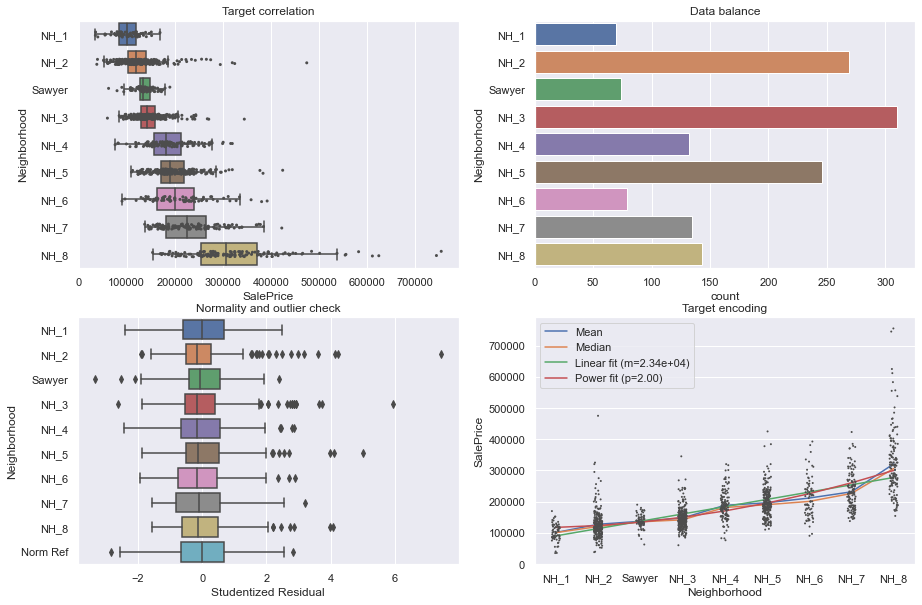

Effect Size
	Classic ANOVA : eta^2 = 0.54
	  Welch ANOVA : eta^2 = 0.54
Tests for no correlation
	Classic ANOVA : F=215.116 (pval = 0.0%)
	Welch   ANOVA : F=164.069 (pval = 0.0%)
	Kruskal ANOVA : H=864.537 (pval = 0.0%)
Tests for homoskedasticity
	Bartlett's test       : 471.070 (pval = 0.0%)
	Levene's test         : 33.843 (pval = 0.0%)
	Kruskal-Wallis H-test : 864.537 (pval = 0.0%; ddof = 8)
Target encoding
	Linear fit : y = 2.34e+04x + 9.00e+04
	Power fit  : y = 2.41e+03 (x - -7.32e-01)^2.00 + 1.16e+05

Category summary


,count,mean,median,std,Normal Skew pval,Normal Kurtosis pval,Normality (Jarque-Bera) pval
Neighborhood,,,,,,,
NH_1,70,100746.857,100500.0,27539.911,0.606,0.620,0.887
NH_2,269,127163.770,120000.0,46691.312,0.000,0.000,0.000
Sawyer,74,136793.135,135000.0,22345.129,0.130,0.048,0.037
NH_3,310,147086.655,141500.0,33215.157,0.000,0.000,0.000
NH_4,132,187935.205,181000.0,46176.323,0.040,0.180,0.062
NH_5,246,196110.476,190000.0,45664.343,0.000,0.000,0.000
NH_6,79,211312.570,200500.0,62565.218,0.011,0.294,0.030
NH_7,135,231219.030,226000.0,60123.713,0.001,0.547,0.001
NH_8,143,320716.231,306000.0,106643.236,0.000,0.000,0.000



Pairwise comparisons : Showing top 10/36 results


,A,B,T-games,p-games
21,NH_4,NH_5,-1.647,0.750
26,NH_5,NH_6,-1.996,0.543
30,NH_6,NH_7,-2.279,0.363
14,NH_2,Sawyer,-2.499,0.237
22,NH_4,NH_6,-2.884,0.102
20,NH_3,Sawyer,3.206,0.042
23,NH_4,NH_7,-6.606,0.001
24,NH_4,NH_8,-13.574,0.001
25,NH_4,Sawyer,10.687,0.001
0,NH_1,NH_2,-6.070,0.001


In [39]:
#cat_num_corr_plots(df_clean, 'RoofMatl', target_var, rare_thr=9)
#cat_num_corr_plots(df_clean, 'OverallQual', target_var, groups={'Low':[1,2,3], 'High':[9,10]})
nh_groups = {
    "NH_1" : ['IDOTRR', 'MeadowV','BrDale'],
    "NH_2" : ['Edwards', 'OldTown','BrkSide'],
    "NH_3" : ['NPkVill', 'SWISU','Blueste','NAmes','Mitchel'],
    "NH_4" : ['SawyerW', 'NWAmes'],
    "NH_5" : ['Blmngtn', 'Gilbert','CollgCr'],
    "NH_6" : ['ClearCr', 'Crawfor'],
    "NH_7" : ['Timber', 'Veenker','Somerst'],
    "NH_8" : ['NridgHt', 'StoneBr','NoRidge'],
}
cat_num_corr_plots(df_clean, 'Neighborhood', target_var, groups=nh_groups) 
#cat_num_corr_plots(df_clean, 'MSSubClass', '2ndFlrSF', rare_thr=10) 
#cat_num_corr_plots(df_clean, 'Utilities', 'BsmtHalfBath', rare_thr=10)
#cat_num_corr_plots(df_clean, 'Condition1', 'BedroomAbvGr', rare_thr=0)

In [21]:
import warnings
def cat_cat_corr_plots(df, x, y): 
    # Preprocess
    cont_tbl = pd.crosstab(index=df[y], columns=df[x])
    x_order = cont_tbl.columns.values
    y_order = cont_tbl.index.values
    sm_cont_tbl = sm.stats.Table(cont_tbl)

    # Visualize
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    ax = axs[0,0]
    ax.set_title(f"Contingency Table")
    sns.heatmap(sm_cont_tbl.table_orig, 
                annot=True, fmt='.0f', 
                cbar=False, center=0, cmap=cmap,
                ax=ax)

    ax = axs[0,1]
    sns.countplot(data=df, y=y, order=y_order, color='b', ax=ax)

    ax = axs[1,0]
    sns.countplot(data=df, x=x, order=x_order, color='b', ax=ax)

    ax = axs[1,1]
    ax.set_title("Expected frequency")
    sns.heatmap(sm_cont_tbl.resid_pearson, 
                annot=sm_cont_tbl.fittedvalues, 
                fmt='.0f', cbar=True, center=0, robust=True, cmap=cmap.reversed(),
                cbar_kws={'label': 'Pearson residual'},
                ax=ax)

    plt.show()
    
    # Quantify
    print("Significance tests")
    if cont_tbl.shape == (2,2):
        oddsratio, pval = stats.fisher_exact(cont_tbl)
        print(f"\t Fisher's Exact Test : Odds Ratio = {oddsratio:.2f} (pval={pval:.1%})")
        # (TODO) Barnard’s test
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', UserWarning)
        warnings.simplefilter('ignore', RuntimeWarning)
        exp_freq, obs_freq, rslt = pg.chi2_independence(df, x, y)
        if exp_freq.min().min() <= 5 or obs_freq.min().min() <= 5:
            print("Warning: Low frequency counts render significance tests much less reliable")
    rslt = rslt.set_index('test')
    display(rslt.round(3))

    print()
    print("Effect size")
    print(f"\t           Tschuprow's T : {util.tschuprows_t(cont_tbl):.2f}")
    print(f'\t  Contingency Coefficent : {util.contingency_coef(cont_tbl):.2f}')
    print(f"\t              Cramer's V : {util.cramers_v(cont_tbl):.2f}")
    ux = util.uncertainty_coef(cont_tbl)
    uy = util.uncertainty_coef(cont_tbl.T)
    u  = util.uncertainty_coef(cont_tbl, sym=True)
    print(f"\t Uncertainty Coefficient : {u:.2f} (Y|X = {uy:.2f}; X|Y = {ux:.2f})")
    lx = util.goodman_kruskals_lambda(cont_tbl)
    ly = util.goodman_kruskals_lambda(cont_tbl.T)
    l  = util.goodman_kruskals_lambda(cont_tbl, sym=True)
    print(f"\tGoodman Kruskal’s lambda : {l:.2f} (Y|X = {ly:.2f}; X|Y = {lx:.2f})")
    pk, pk_pval, pk_z = util.phik_coef(cont_tbl)
    print(f"\t                    PhiK : {pk:.2f} (pval={pk_pval:.1%}; Z={pk_z:.2f})")

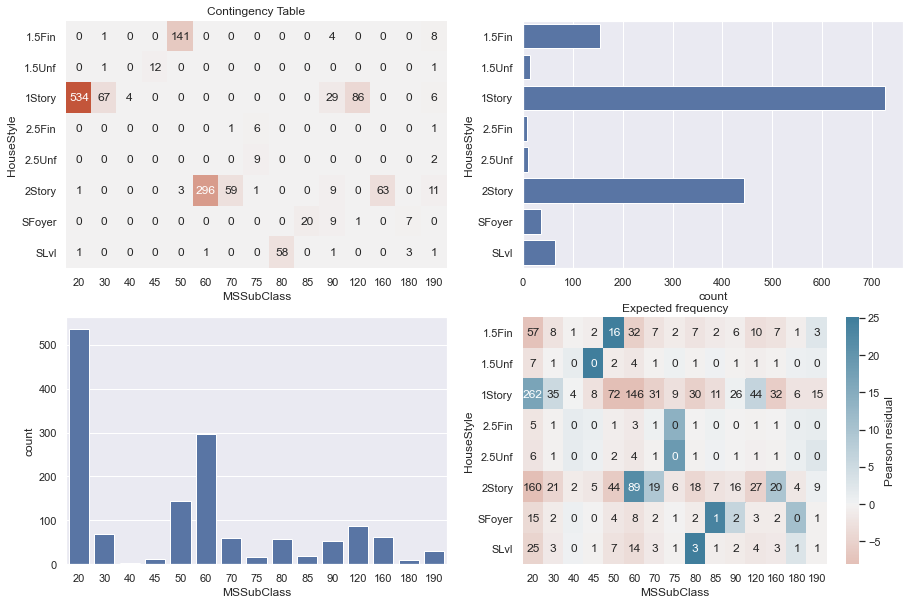

Significance tests


,lambda,chi2,dof,pval,cramer,power
test,,,,,,
pearson,1.000,7401.147,98.0,0.0,0.852,1.0
cressie-read,0.667,4677.022,98.0,0.0,0.677,1.0
log-likelihood,0.000,3384.589,98.0,0.0,0.576,1.0
freeman-tukey,-0.500,NaN,98.0,NaN,NaN,NaN
mod-log-likelihood,-1.000,inf,98.0,0.0,inf,1.0
neyman,-2.000,NaN,98.0,NaN,NaN,NaN



Effect size
	           Tschuprow's T : 0.72
	  Contingency Coefficent : 0.96
	              Cramer's V : 0.85
	 Uncertainty Coefficient : 0.70 (Y|X = 0.90; X|Y = 0.57)
	Goodman Kruskal’s lambda : 0.73 (Y|X = 0.59; X|Y = 0.92)
	                    PhiK : 0.96 (pval=0.0%; Z=54.32)


In [41]:
#cat_cat_corr_plots(df_clean, "GarageType", "GarageFinish")
#cat_cat_corr_plots(df_clean, "MSSubClass", "BldgType")
cat_cat_corr_plots(df_clean, "MSSubClass", "HouseStyle")
#cat_cat_corr_plots(df_clean, "Exterior1st", "Exterior2nd")
#cat_cat_corr_plots(df_clean, "BsmtQual", "BsmtFinType1")

<a id="sec_selection"></a>
## Feature Selection
[top](#sec_toc)

In [23]:
## Square Footage formulas
# GrLivArea = 1stFlrSF + 2ndFlrSF + LowQualFinSF
# TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF
# LotArea
# MasVnrArea
# GarageArea
# WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch (Mutually exclusive?)
# PoolArea

In [24]:
def num_num_correlation_matrix(df, corr_mask=None, sig_thr=1, method='pearson'):
    """
    Available correlation measures: Pearson's r, R2, Spearman's r, MI
    """
    n = len(df.columns)
    if method == 'spearman':
        corr = df.rcorr(stars=False, method='spearman').replace('-',1).astype(float)
        sig = np.tril(corr.T, k=-1)
    elif method == 'MI':
        pass #(TODO)
    else: # pearson or R2
        corr = df.rcorr(stars=False, method='pearson').replace('-',1).astype(float)
        sig = np.tril(corr.T, k=-1)
        if method == 'R2':
            corr = corr**2
    
    mask = np.diag([True]*n) # Hide diagonal
    mask = np.tril(mask == False) == False
    mask |= sig > sig_thr # Mask r values with low significance    
        
    # Mask r values for user specified feature
    if not corr_mask:
        corr_mask = []
    elif len(corr_mask) > 1 and type(corr_mask[0]) is not list:
        corr_mask = [corr_mask]
    for features in corr_mask:
        for f1, f2 in itertools.combinations(features, 2):
            row, col = corr.index.get_loc(f1), corr.index.get_loc(f2)
            if row < col: # Focus on bottom triangle
                row, col = col, row
            mask[row, col] = True
    
    fs = max(4, n//2)
    fig, ax = plt.subplots(1,figsize=(fs,fs))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr*100, 
                mask=mask, annot=True, fmt='.0f',
                cmap=cmap,
                center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},)
    ax.set_title(f"Numerical correlation ({method})")

def num_cat_correlation_matrix(df, num, cat):
    return 

def cat_num_correlation_matrix(df, num_cols, cat_cols, sig_thr=1, r2_adj=True):
    """
    Available correlation measures: R2 (a.k.a. eta2), R2_adj
    """
    n = len(df)
    corr = pd.DataFrame(np.zeros((len(num_cols),len(cat_cols))),
                        index=num_cols, columns=cat_cols)
    sig = corr.copy()
    min_count = {}
    for num, cat in itertools.product(num_cols, cat_cols):
        if cat not in min_count:
            min_count[cat] = df[cat].value_counts().min()
        if min_count[cat] > 1 and df.groupby(cat)[num].agg('var').min() > 0:
            r2, pval = pg.welch_anova(data=df, dv=num, between=cat).loc[0,['np2','p-unc']] 
        else:
            r2, pval = 0, 2 # Will get masked by sig_thr
        if r2_adj:
            k = df[cat].nunique()
            r2 = max(0, util.r2_adjusted(r2,n,k))
        corr.loc[num,cat] = r2
        sig.loc[num,cat] = pval
        
    # Mask r values with with low significance
    mask = sig.astype(float) > sig_thr
    
    fs = max(4, len(num_cols)//2, len(cat_cols)//2)
    fig, ax = plt.subplots(1,figsize=(fs,fs))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr*100, 
                mask=mask, annot=True, fmt='.0f',
                cmap=cmap, center=0, vmin=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},)
    corr_name = "R2"
    if r2_adj:
        corr_name += " adjusted"
    ax.set_title(f"Numerical | Categorical correlation ({corr_name})")
    ax.set_xlabel("Categorical Features")
    ax.set_ylabel("Numerical Features")


import phik
def cat_cat_correlation_matrix(df, sig_thr=1, method='L', hide_triu=True):
    """
    Available correlation measures: Tschuprow's T, Cramer's V, Goodman-Kruskal’s lambda, or PhiK
    """
    n = len(df.columns)
    corr = pd.DataFrame(np.zeros((n,n)), index=df.columns, columns=df.columns)
    sig  = corr.copy()
    if method == 'K':
        corr = df.phik_matrix(interval_cols=[])
        if sig_thr < 1:
            sig = df.significance_matrix(interval_cols=[])  
    else:
        for f1, f2 in itertools.permutations(corr.index, 2):
            row, col = corr.index.get_loc(f1), corr.index.get_loc(f2)
            if row == col:
                continue
            if row < col and hide_triu: # Focus on lower triangle
                continue
            cont_tbl = pd.crosstab(index=df[f1], columns=df[f2])
            if method == 'T':
                val = util.tschuprows_t(cont_tbl)
            elif method == 'C':
                val = util.contingency_coef(cont_tbl)
            elif method == 'V':
                val = util.cramers_v(cont_tbl)
            elif method == 'L':
                val = util.goodman_kruskals_lambda(cont_tbl, sym=hide_triu)
            elif method == 'U':
                val = util.uncertainty_coef(cont_tbl, sym=hide_triu)
            else:
                val = 0
            corr.iloc[row, col] = val
            if method in ['T', 'C', 'V']: # chi2 based measures
                sig.iloc[row,col] = stats.chi2_contingency(cont_tbl)[1]
    

    # Build mask
    mask = np.diag([True]*n) # Hide diagonal
    if hide_triu:
        mask = np.tril(mask == False) == False
    mask |= sig > sig_thr # Mask r values with low significance

    fs = max(4, n//2)
    fig, ax = plt.subplots(1,figsize=(fs,fs))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr*100, 
                mask=mask, annot=True, fmt='.0f',
                cmap=cmap, center=0, vmin=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},)
    if method == 'K':
        method_name = '$\phi_{K}$'
    elif method == 'T':
        method_name = "Tschuprow's $T$"
    elif method == 'C':
        method_name = "Contingency Coefficient"
    elif method == 'V':
        method_name = "Cramer's $V$"
    elif method == 'L':
        method_name = "Goodman-Kruskal's $\lambda$"
    elif method == 'U':
        method_name = "Uncertainty Coefficient / Theil's $U$"
    else:
        method_name = "Method?"
    ax.set_title(f"Categorical Correlations ({method_name})")


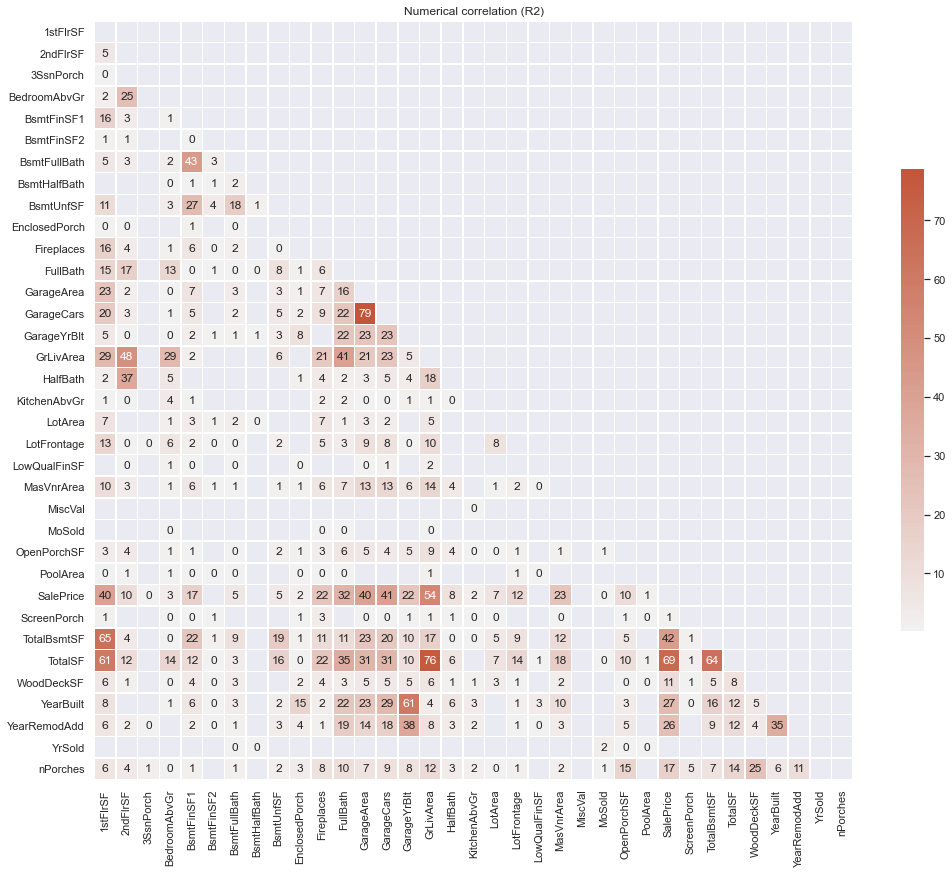

In [25]:
num_num_correlation_matrix(df_clean[num_cols], sig_thr = 0.1, method='R2')
corr_mask = [
    ['GarageCars', 'GarageArea'],
    ['YearBuilt','GarageYrBlt','YearRemodAdd']
]
#num_num_correlation_matrix(df_clean[num_cols], corr_mask, sig_thr = 0.1)

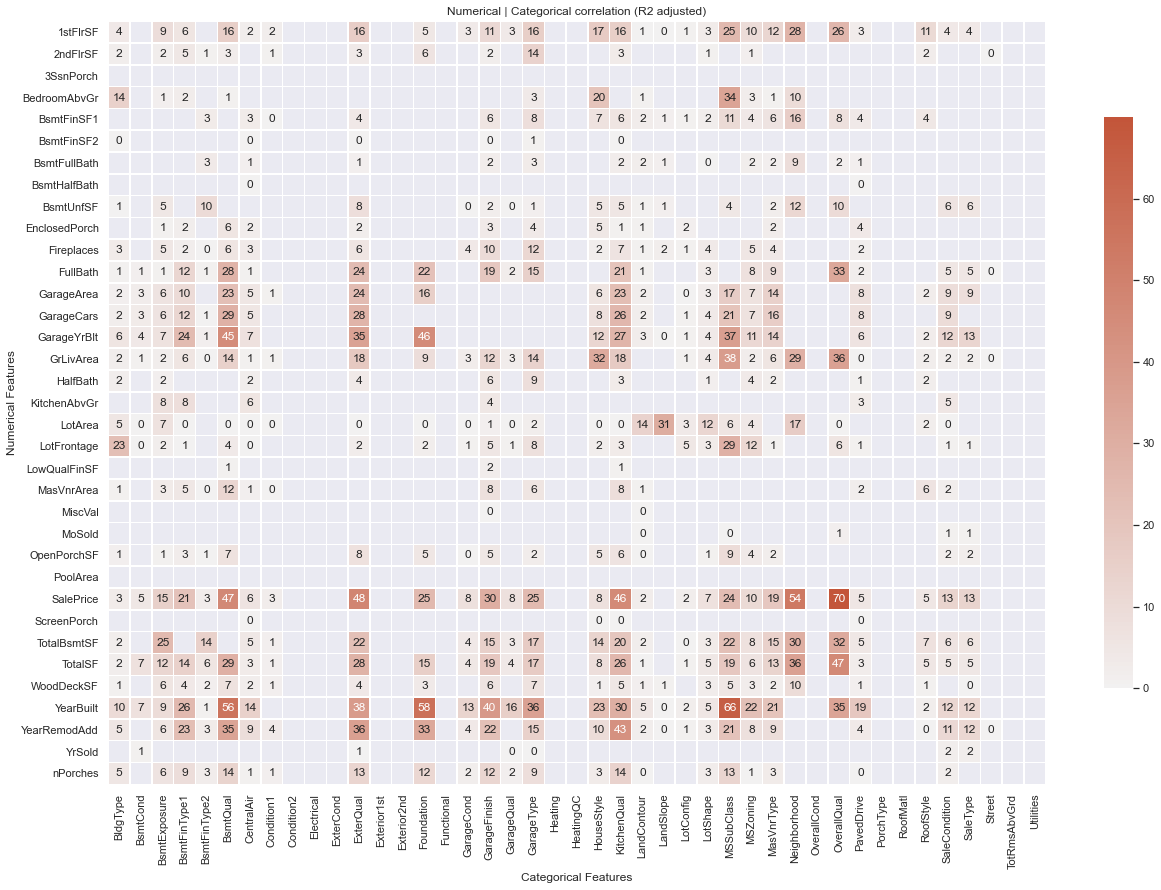

In [26]:
cat_num_correlation_matrix(df_clean, num_cols, cat_cols, sig_thr=0.1)
#cat_num_correlation_matrix(df_clean, ['BsmtHalfBath','GrLivArea','OpenPorchSF','YearRemodAdd'], ['TotRmsAbvGrd','TotRmsAbvGrd','ExterQual','GarageQual'], sig_thr=0.1)

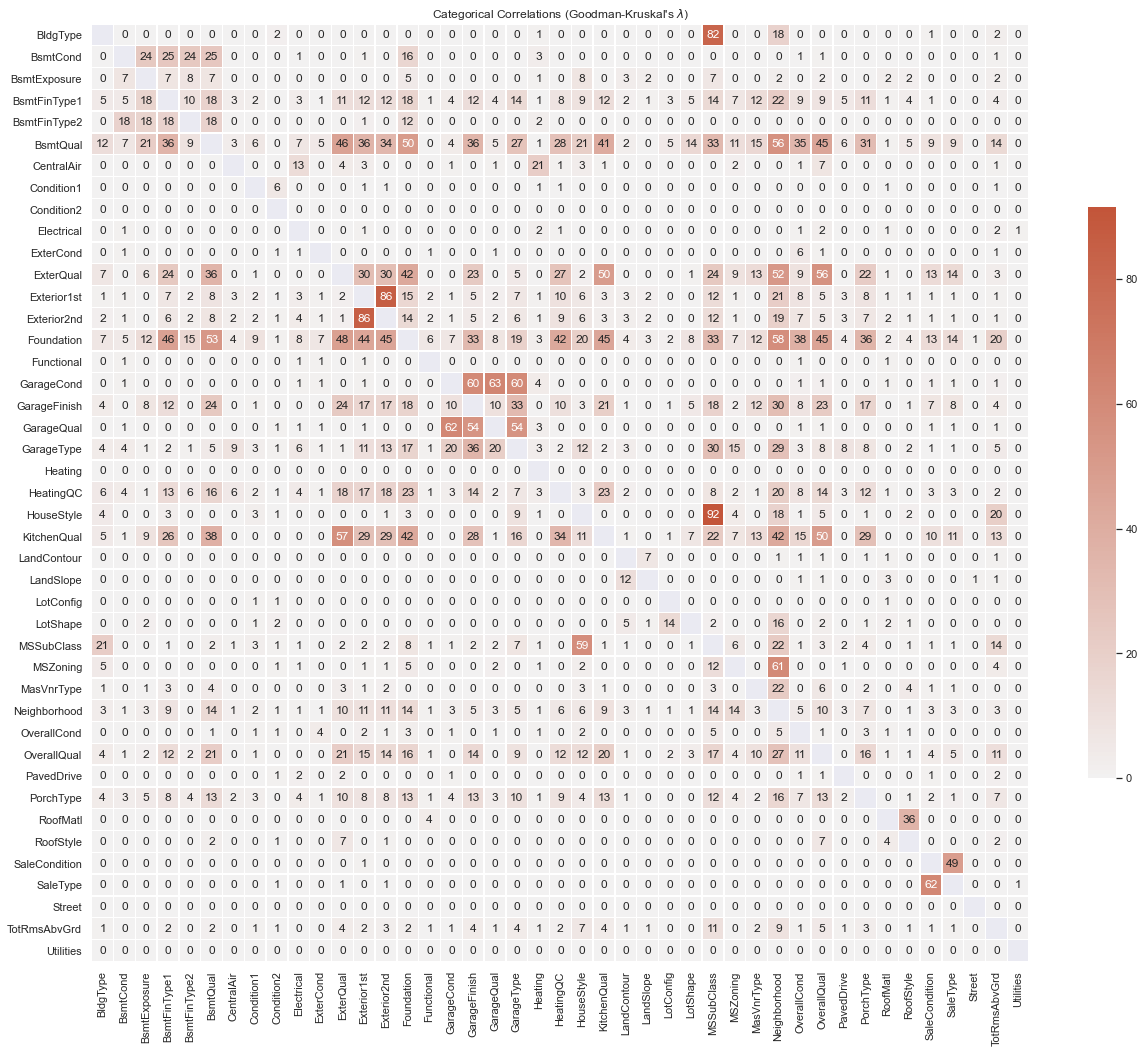

In [27]:
cat_cat_correlation_matrix(df_clean[cat_cols], method='L', hide_triu=False)
#cat_cat_correlation_matrix(df_clean[cat_cols], method='T', sig_thr=0.1)
#cat_cat_correlation_matrix(df_clean[cat_cols], method='K', sig_thr=0.1)

In [28]:
alpha = 0.05
target_corr = util.corr_to_target(df_clean, target_var, cat_cols)
target_corr = target_corr.sort_values(['Categorical','R2_adj'], ascending=False)
ranked_f = target_corr.loc[target_corr['pval'] < alpha,:]
display(ranked_f)

,Categorical,R2,R2_adj,pval
OverallQual,1,0.701517,0.699454,6.654779e-18
Neighborhood,1,0.546018,0.538092,2.854451e-54
ExterQual,1,0.485984,0.484569,7.543953e-32
BsmtQual,1,0.470284,0.468460,2.534215e-58
KitchenQual,1,0.462012,0.460531,8.226150e-60
GarageFinish,1,0.306873,0.304965,4.922580e-89
Foundation,1,0.256974,0.253901,9.674785e-11
GarageType,1,0.249906,0.246285,4.552924e-24
MSSubClass,1,0.247311,0.239481,9.230925e-43
BsmtFinType1,1,0.211672,0.207867,1.201595e-55


In [29]:
import sys
from copy import copy
def get_formula(y, X, cat_vars):
    f = f"{y} ~ 1"
    for v in X:
        f += f' + C(Q("{v}"))' if v in cat_vars else f' + Q("{v}")'
    return f
from collections import namedtuple
Rank = namedtuple('Rank',['r2_adj','aic', 'bic'])
def rank(model):
    return Rank(model.rsquared_adj, model.aic, model.bic)
def higher_rank(r1, r2):
    ''' Check if r1 rank is higher than r2'''
    #return r2.r2_adj < r1.r2_adj
    #return r2.aic > r1.aic
    return r2.bic > r1.bic
    
def print_rank(var, r, sign='+'):
    print(f" {sign} {var:20}: AIC = {r.aic: .6}; BIC = {r.bic: .6}; R2 adj = {r.r2_adj: .6}")
def print_rank_cf(r1, r2):
    d_aic = r2.aic - r1.aic
    d_bic = r2.bic - r1.bic
    d_r2  = r2.r2_adj - r1.r2_adj
    d_rel_aic = d_aic / r1.aic
    d_rel_bic = d_bic / r1.bic
    d_rel_r2  = d_r2  / r1.r2_adj
    print(f' ^ {"Change":20}:',
          f'AIC = {d_aic:.2f} ({d_rel_aic:.1%});',
          f'BIC = {d_bic:.2f} ({d_rel_bic:.1%});',
          f'R2_adj = {d_r2:.4f} ({d_rel_r2:.1%});'
         )
    
    
import statsmodels.formula.api as smf

def mixed_selection(df, target_var, categorical_vars, backward_sel=False):
    # Inspired by http://web.vu.lt/mif/a.buteikis/wp-content/uploads/PE_Book/4-9-MultipleModellingChallenges.html#variable-selection-algorithms-stepwise-regression-or-stepwise-selection
    X = df.drop(columns=target_var)
    y = df[target_var]
    included_vars = []
    to_include = X.columns.to_list()
    ols_formula = get_formula(target_var, included_vars, categorical_vars)
    model = smf.ols(formula=ols_formula, data=df).fit()
    print('\nModel: Y ~', " + ".join(included_vars), " + C")
    print_rank('<none>', rank(model))
    prev_rank = rank(model)
        
    while True:
        if len(to_include) == 0:
            break # No more variables
            
        # Forward selection:
        new_var = ''
        max_rank = copy(prev_rank)
        for j, var in enumerate(to_include):
            print(f'{j+1:>3}/{len(to_include):3} variables tested\r', end='')
            sys.stdout.flush()
            temp_formula = get_formula(target_var, included_vars+[var], categorical_vars)
            temp_model = smf.ols(formula=temp_formula, data=df).fit()
            r = rank(temp_model)
            if higher_rank(r, max_rank) and r.r2_adj-max_rank.r2_adj >= 0.001:
                model = temp_model
                max_rank = r
                new_var = var
        if not new_var:
            # No variables to add and the previous iteration already dropped insignificant variables
            # So, this is the optimal model
            break;
        included_vars.append(new_var)
        to_include.remove(new_var)
        
        # Backward selection / recursive elimination
#         rm_var = ''
#         to_exclude = included_vars.copy() if backward_sel else []
#         for j in to_exclude:
#             restricted_vars = [v for v in included_vars if v != j and v != new_var]
#             temp_formula = get_formula(target_var, restricted_vars, categorical_vars)
#             temp_model = smf.ols(formula=temp_formula, data=df).fit()
#             r = rank(temp_model)
#             if higher_rank(r, max_rank):
#                 model = temp_model
#                 max_rank = r
#                 included_vars.remove(j)
#                 to_include.append(j)
#                 print_rank(j, max_rank, sign='-')
        
        print('\nModel: Y ~', " + ".join(included_vars), "+ const")
        print_rank(new_var, max_rank)
        print_rank_cf(prev_rank, max_rank)
        prev_rank = max_rank
        print()
    
    print('\nModel: Y ~', " + ".join(included_vars), " + const ")
    print_rank('FINAL', rank(model))
    # Return variable list and the estimated model object
    return (included_vars, model)

In [30]:
X_train = df_clean.drop(columns=target_var)
y_train = df_clean[target_var]
sel_features, model = mixed_selection(df_clean, target_var, cat_cols)
print(sel_features)


Model: Y ~   + C
 + <none>              : AIC =  37041.2; BIC =  37046.4; R2 adj = -2.22045e-16
 77/ 77 variables tested
Model: Y ~ OverallQual + const
 + OverallQual         : AIC =  35296.4; BIC =  35349.2; R2 adj =  0.699662
 ^ Change              : AIC = -1744.78 (-4.7%); BIC = -1697.22 (-4.6%); R2_adj = 0.6997 (-315099756191456064.0%);

 76/ 76 variables tested
Model: Y ~ OverallQual + TotalSF + const
 + TotalSF             : AIC =  34486.2; BIC =  34544.3; R2 adj =  0.827823
 ^ Change              : AIC = -810.22 (-2.3%); BIC = -804.93 (-2.3%); R2_adj = 0.1282 (18.3%);

 75/ 75 variables tested
Model: Y ~ OverallQual + TotalSF + Neighborhood + const
 + Neighborhood        : AIC =  34244.1; BIC =  34429.1; R2 adj =  0.856502
 ^ Change              : AIC = -242.04 (-0.7%); BIC = -115.20 (-0.3%); R2_adj = 0.0287 (3.5%);

 74/ 74 variables tested
Model: Y ~ OverallQual + TotalSF + Neighborhood + BsmtUnfSF + const
 + BsmtUnfSF           : AIC =  34066.6; BIC =  34256.8; R2 adj =  0.8

In [100]:
# Old Foward Selection
alpha = 0.1
df = df_clean
cat_features = cat_cols
sequential = True

df_tmp = df.copy()
df_tmp['Residual'] = df_tmp[target_var] - df_tmp[target_var].mean()
n_sig_corr = len(df_tmp.columns)
results = []
sel_features = ['TotalSF']
clf = LinearRegression()
enc = OneHotEncoder(drop='first', sparse=False)
print('Starting feature selection...', end='')
while n_sig_corr > 1:
    # Prepare data
    df_unused = df_tmp.drop(columns=sel_features+[target_var])
    
    # Rank features
    target_corr = util.corr_to_target(df_unused, 'Residual', cat_features).sort_values('R2_adj', ascending=False)
    ranked_f = target_corr.index[target_corr['pval'] < alpha]
    n_sig_corr = len(ranked_f)
    
    # Save results
    print(f"Model {i}: Y ~ const + ", " + ".join([selected_vars]))
    print(ranked_f.iloc[:3])
    result = {}
    if n_sig_corr >= 1: 
        result['1st place'] = ranked_f[0]
        result['R2 adj']         = target_corr.loc[ranked_f[0], 'R2_adj']
        result['pval']      = target_corr.loc[ranked_f[0], 'pval']
        print(f'{ranked_f[0]} (R2_adj={result["R2_adj"]:.1%})...',end='')
    if n_sig_corr >= 2: 
        result['2nd place'] = ranked_f[1]
        result['2nd R2 adj']     = target_corr.loc[ranked_f[1], 'R2_adj']
        result['2nd pval']  = target_corr.loc[ranked_f[1], 'pval']
    if n_sig_corr >= 3: 
        result['3rd place'] = ranked_f[2]
        result['3rd R2 adj']     = target_corr.loc[ranked_f[2], 'R2_adj']
        result['3rd pval']  = target_corr.loc[ranked_f[2], 'pval']
    results.append(result)
    is_categorical = (ranked_f[0] in cat_features) or (df_tmp[ranked_f[0]].dtype == 'object')
    
    # Fit with best features
    sel_features.append(ranked_f[0])
    X = df_tmp[sel_features].copy()
    y = df_tmp[target_var]

    # One hot encoding of categorical features
    sel_cat_f = [f for f in sel_features if f in cat_features]
    enc.fit(X[sel_cat_f])
    onehot_features = enc.get_feature_names(sel_cat_f)
    X.loc[:,onehot_features] = enc.transform(X[sel_cat_f]).astype('int')
    X = X.drop(columns=sel_cat_f)
    
#     X, y = df_tmp[[ranked_f[0]]], df_tmp[target_var]
    
#     if is_categorical:
#         X = pd.DataFrame(enc.fit_transform(X).astype('int'))
#         X.columns = enc.get_feature_names([ranked_f[0]])

    y_pred = clf.fit(X, y).predict(X)
    df_tmp['Residual'] = y - y_pred

print()
    
df_sel_features = pd.DataFrame(results)
df_unsel_features = util.corr_to_target(df_tmp, target_var, cat_features).sort_values('R2', ascending=False)

display(df_sel_features)
display(df_unsel_features)

Starting feature selection...OverallQual (R2=69.9%)...Neighborhood (R2=10.7%)...BsmtUnfSF (R2=8.5%)...SaleCondition (R2=6.2%)...MSSubClass (R2=4.4%)...BsmtExposure (R2=3.5%)...YearRemodAdd (R2=1.9%)...LotArea (R2=2.0%)...GarageType (R2=1.3%)...BsmtFinSF2 (R2=1.0%)...PoolArea (R2=1.0%)...BsmtCond (R2=0.9%)...ScreenPorch (R2=0.7%)...BsmtQual (R2=0.8%)...LotConfig (R2=0.5%)...Condition1 (R2=0.4%)...MasVnrType (R2=0.6%)...GarageCars (R2=0.4%)...MSZoning (R2=0.4%)...3SsnPorch (R2=0.2%)...MoSold (R2=0.2%)...KitchenAbvGr (R2=0.2%)...LowQualFinSF (R2=0.2%)...MasVnrArea (R2=0.2%)...CentralAir (R2=0.1%)...OpenPorchSF (R2=0.1%)...GarageCond (R2=-0.1%)...


,1st place,R2,pval,2nd place,2nd R2,2nd pval,3rd place,3rd R2,3rd pval
0,OverallQual,0.699454,6.654779e-18,GrLivArea,0.539862,6.591113e-248,Neighborhood,0.538092,2.854451e-54
1,Neighborhood,0.107313,1.552471e-18,MSSubClass,0.104655,1.813836e-17,BsmtUnfSF,0.098812,5.097892e-35
2,BsmtUnfSF,0.085376,2.615161e-30,BsmtExposure,0.054370,1.073295e-13,MSSubClass,0.052954,2.111593e-11
3,SaleCondition,0.061678,8.772488e-05,SaleType,0.054043,9.587009e-11,MSSubClass,0.050890,7.615645e-11
4,MSSubClass,0.044388,7.899885e-10,KitchenAbvGr,0.031654,4.680918e-12,BldgType,0.031216,3.400747e-10
5,BsmtExposure,0.035351,2.107125e-10,LotArea,0.025740,4.336543e-10,BsmtFinType1,0.020507,4.773537e-11
6,YearRemodAdd,0.019472,5.254975e-08,LotArea,0.017377,2.617328e-07,KitchenQual,0.017312,2.996044e-04
7,LotArea,0.020243,2.912513e-08,GarageType,0.012927,4.665288e-03,GarageCars,0.011096,3.295652e-05
8,GarageType,0.012505,5.954997e-03,BsmtFinSF2,0.011052,3.409727e-05,KitchenQual,0.010489,5.780850e-02
9,BsmtFinSF2,0.010180,6.704832e-05,PoolArea,0.008759,2.029231e-04,BsmtCond,0.008359,4.077187e-02


,Categorical,R2,R2_adj,pval
OverallQual,1,0.701517,0.699454,6.654779e-18
TotalSF,0,0.687311,0.687096,0.000000e+00
Neighborhood,1,0.546018,0.538092,2.854451e-54
GrLivArea,0,0.540178,0.539862,6.591113e-248
ExterQual,1,0.485984,0.484569,7.543953e-32
...,...,...,...,...
HeatingQC,1,NaN,NaN,NaN
Electrical,1,NaN,NaN,NaN
TotRmsAbvGrd,1,NaN,NaN,NaN
Functional,1,NaN,NaN,NaN


In [31]:
# Categorical Features
#kbest = 5
#selected_cat_cols = df_features.loc[cat_cols,:].sort_values('MI_C', ascending=False).index[:kbest].tolist()
selected_cat_cols = [f for f in sel_features if f in cat_cols]
print('Categorical Features:')
display(selected_cat_cols)

# Numerical Features
#kbest = 20
#selected_num_cols = df_features.loc[num_cols,:].sort_values('MI_R', ascending=False).index[:kbest+1].drop(target_var).tolist()
selected_num_cols = [f for f in sel_features if f in num_cols]
print('Numerical Features:')
display(selected_num_cols)

Categorical Features:


['OverallQual',
 'Neighborhood',
 'MSSubClass',
 'OverallCond',
 'SaleCondition',
 'BsmtExposure',
 'BsmtQual',
 'KitchenQual']

Numerical Features:


['TotalSF', 'BsmtUnfSF', 'YearBuilt', 'LotArea', '2ndFlrSF', 'GarageCars']

<a id="sec_transformation"></a>
## Feature Transformation
[top](#sec_toc)

In [32]:
columns_to_keep = selected_num_cols + selected_cat_cols + ['SalePrice']
df_final = df_clean.loc[:,columns_to_keep]

encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(df_clean[selected_cat_cols])
onehot_features = encoder.get_feature_names(selected_cat_cols)
df_final.loc[:,onehot_features] = encoder.transform(df_final[selected_cat_cols])
df_final.loc[:,onehot_features] = df_final.astype({k:'int' for k in onehot_features})
df_final = df_final.drop(columns=selected_cat_cols)
print(columns_to_keep)

['TotalSF', 'BsmtUnfSF', 'YearBuilt', 'LotArea', '2ndFlrSF', 'GarageCars', 'OverallQual', 'Neighborhood', 'MSSubClass', 'OverallCond', 'SaleCondition', 'BsmtExposure', 'BsmtQual', 'KitchenQual', 'SalePrice']


<a id="sec_model"></a>
## Model Building
[top](#sec_toc)

In [33]:
clf = LinearRegression()
pt = PowerTransformer('box-cox', standardize=True)
#clf = TransformedTargetRegressor(regressor=clf, transformer=pt)

X_train = df_final.drop(columns=target_var)
y_train = df_final[target_var]

rmse_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = np.sort(np.abs(rmse_scores))
msle_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_log_error')
msle_scores = np.sort(np.abs(msle_scores))
rmsle_scores = np.sqrt(msle_scores)
mape_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')
mape_scores = np.sort(np.abs(mape_scores))

n_features_used = len(columns_to_keep)-1
n_features = len(df_features.index)-1
print(f'Using {n_features_used} out of {n_features} features.  {len(X_train.columns)} initial features.')
print(f'Overall RMSE : ${round(rmse_scores.mean(),-3):n} +/- {round(rmse_scores.std(ddof=1),-3):n}')
print('\t', [f'${round(x,3):n}' for x in rmse_scores])
print(f'Overall MSLE : {round(msle_scores.mean(),3):n} +/- {round(msle_scores.std(ddof=1),3):n}')
print('\t', [f'{round(x,3):n}' for x in msle_scores])
print(f'Overall RMSLE : {round(rmsle_scores.mean(),3):n} +/- {round(rmsle_scores.std(ddof=1),3):n}')
print('\t', [f'{round(x,3):n}' for x in rmsle_scores])
print(f'Overall MAPE : {mape_scores.mean():.1%} +/- {mape_scores.std(ddof=1):.1%}')
print('\t', [f'{x:.3%}' for x in mape_scores])

Using 14 out of 75 features.  77 initial features.
Overall RMSE : $23000 +/- 2000
	 ['$21255', '$22150.5', '$22297.9', '$24277.1', '$27385.8']
Overall MSLE : 0.017 +/- 0.002
	 ['0.015', '0.015', '0.018', '0.018', '0.021']
Overall RMSLE : 0.131 +/- 0.009
	 ['0.121', '0.124', '0.133', '0.135', '0.144']
Overall MAPE : 9.4% +/- 0.4%
	 ['9.067%', '9.146%', '9.366%', '9.492%', '10.122%']


### Log of progress
* 5-fold CV RMSE score
    * \$33000 +/- 5000 (Feb 24) - First time using numerical and categorical features
    * \$30000 +/- 6000 (Mar 6)  - Used stepwise forward selection of features based on R2
    * \$25000 +/- 2000 (Mar 16) - Removal of 2 outliers : Id = 1298, 523. Both had huge properties but the lowest prices. Either a corruption or unique property not worth training to
        * 0.019 +/- 0.003 mean squared log error
        * 10.0\% +/- 0.7 mean absolute percentage error
    * \$23000 +/- 2000 (Apr 29) - Updated step-forward feature selection to assess full model fit as opposed to sequential fit to residuals. Similar results comparing BIC until no improvements or with improvement to R2_adj <0.001 for all remaining features.
        * 0.017 +/- 0.003
        * 9.4\% +/- 0.3
        

* Potential improvements before running on test data (see post-mortem below)
    * Study power transformations of target and features
    * Try other models : 
        * Ridge/ElasticNet regression
        * Decision Tree
        * AdaBoost & XGBoost
    * More Feature engineering
        * Regrouping of categorical variables with low stats or similar avg Sale Price
        * Domain knowledge informed grouping of features
    * Improve imputation of missing values (e.g. relative to groups)
    * Target encoding

<a id="sec_post"></a>
## Post-mortem
[top](#sec_toc)

In [34]:
X_train = df_final.drop(columns=target_var)
y_train = df_final[target_var]

clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
residual = y_train-y_pred

df_pm = df_clean.copy()
df_pm['SalePrice Pred'] = y_pred
df_pm['Residual'] = residual

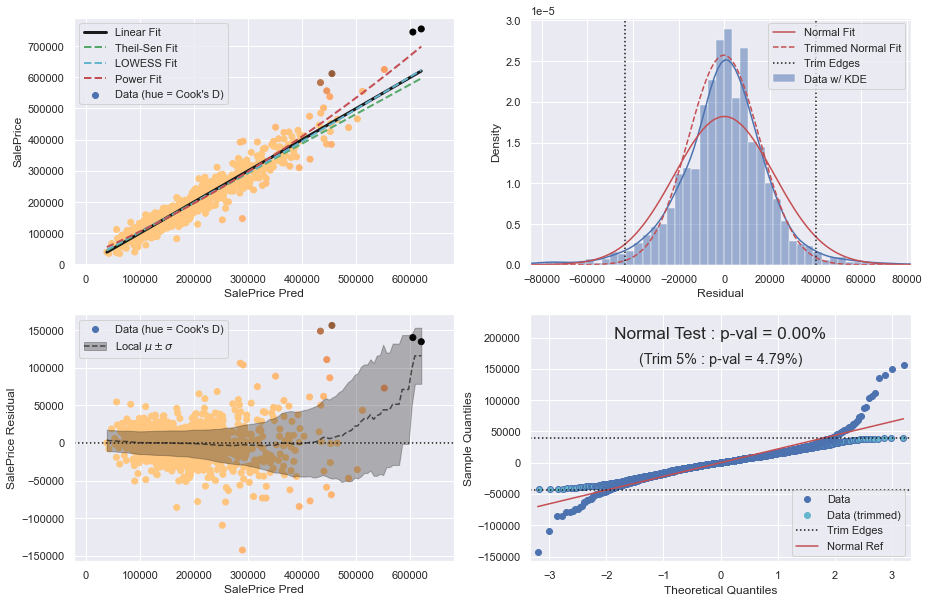

Correlation Measures:
	      OLS Fit Slope = 1.00 +/- 0.01 (pval = 0.0%)
	        Pearson's r = 0.96 (pval = 0.0%; R2 = 0.92)
	    Theil-Sen Slope = 0.95 (95% CI = [0.93,0.96])
	       Spearman's r = 0.96 (pval = 0.0%)
	          Power fit = 5.61e-07 (x - -6.57e+05)^2.00 + -2.16e+05
	 Mutual information = 1.359

Homoscedasticity Tests on Residuals: 
	 Breusch-Pagan p-value = 0.0%

Normality Tests on Residuals : 
	D'Agostino-Pearson p-value = 0.0%
	   Normal Kurtosis p-value = 0.0%
	       Normal Skew p-value = 0.0%

Outlier Scores : Top 10 from 42/1458 flagged features


,SalePrice Pred,SalePrice,mad_resid,hat_diag,standard_resid,cooks_d,student_resid,dffits
Id,,,,,,,,
1182,604613.634180,745000.0,16.162652,0.021787,6.470592,0.466258,6.563426,0.979523
691,620102.904463,755000.0,15.695961,0.023358,6.222583,0.463038,6.304846,0.975051
898,455082.012551,611657.0,17.023644,0.009521,7.171920,0.247213,7.299553,0.715668
803,433914.422281,582933.0,16.170360,0.008209,6.821284,0.192567,6.930582,0.630536
1046,445554.995321,556581.0,12.466057,0.008917,5.084000,0.116282,5.127974,0.486421
1169,551873.731132,625000.0,9.240771,0.016861,3.362030,0.096925,3.373998,0.441851
769,451221.775355,538000.0,10.093136,0.009274,3.974383,0.073929,3.994746,0.386493
178,439681.062918,501837.0,7.597741,0.008556,2.845668,0.034942,2.852635,0.265002
473,351002.419262,440000.0,9.815578,0.004086,4.065397,0.033903,4.087265,0.261798


In [44]:
num_num_corr_plots(df_pm, 'SalePrice Pred', 'SalePrice', maxfev=5000)
plt.show()

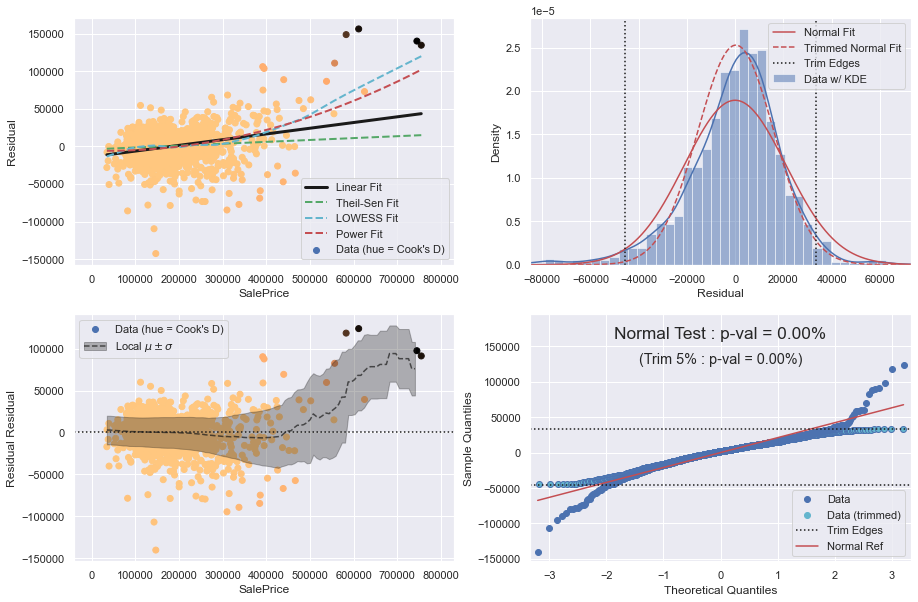

Correlation Measures:
	      OLS Fit Slope = 0.08 +/- 0.01 (pval = 0.0%)
	        Pearson's r = 0.28 (pval = 0.0%; R2 = 0.08)
	    Theil-Sen Slope = 0.03 (95% CI = [0.01,0.04])
	       Spearman's r = 0.08 (pval = 0.2%)
	          Power fit = 2.08e-07 (x - 3.42e+04)^2.00 + -5.79e+03
	 Mutual information = 0.058

Homoscedasticity Tests on Residuals: 
	 Breusch-Pagan p-value = 0.0%

Normality Tests on Residuals : 
	D'Agostino-Pearson p-value = 0.0%
	   Normal Kurtosis p-value = 0.0%
	       Normal Skew p-value = 0.0%

Outlier Scores : Top 10 from 35/1458 flagged features


,SalePrice,Residual,mad_resid,hat_diag,standard_resid,cooks_d,student_resid,dffits
Id,,,,,,,,
1182,745000.0,140386.365820,12.221652,0.035242,4.706066,0.404506,4.740643,0.906059
898,611657.0,156574.987449,14.122527,0.020835,5.933525,0.374572,6.004527,0.875888
691,755000.0,134897.095537,11.663086,0.036478,4.407099,0.367657,4.435267,0.862985
803,582933.0,149018.577719,13.457367,0.018237,5.668601,0.298453,5.730239,0.780998
1046,556581.0,111026.004679,9.824740,0.016012,3.941600,0.126404,3.961438,0.505331
769,538000.0,86778.224645,7.510614,0.014533,2.847753,0.059798,2.854736,0.346675
688,392000.0,106357.875961,9.772367,0.005524,4.294354,0.051221,4.320326,0.322001
774,395000.0,103912.608322,9.527098,0.005663,4.167495,0.049456,4.191136,0.316286
473,440000.0,88997.580738,7.965870,0.007975,3.299092,0.043750,3.310355,0.296813


In [36]:
num_num_corr_plots(df_pm, 'SalePrice', 'Residual')
plt.show()

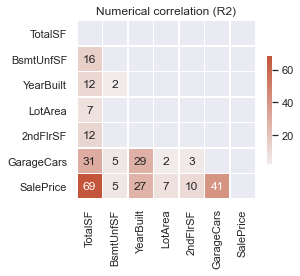

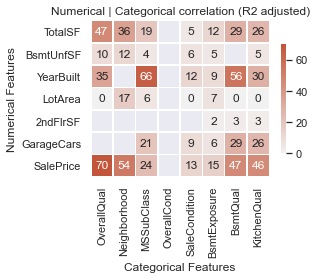

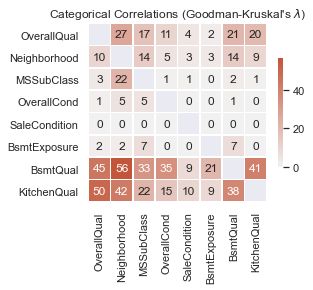

In [37]:
num_num_correlation_matrix(df_clean[selected_num_cols+[target_var]], sig_thr = 0.1, method='R2')
plt.show()
cat_num_correlation_matrix(df_clean, selected_num_cols+[target_var], selected_cat_cols, sig_thr=0.1)
plt.show()
cat_cat_correlation_matrix(df_clean[selected_cat_cols], method='L', hide_triu=False)
plt.show()

<a id="sec_appendix"></a>
# Appendix
[top](#sec_toc)

## Compare Train and Test Inputs

In [31]:
# Check test data is similar to training data
result = defaultdict(dict)
for f in df_features.index.drop([target_var]):
    if df_features.loc[f,'Data Subtype'] != 'Continuous':
        unique_train = set(df_train[f].dropna().unique())
        unique_test  = set(df_test[f].dropna().unique())
        if unique_train - unique_test:
            result['Unique Train Values'][f] = unique_train - unique_test
        if unique_test  - unique_train: 
            result['Unique Test Values'][f] = unique_test - unique_train
    null_in_train = df_train[f].isnull().sum() > 0
    null_in_test  =  df_test[f].isnull().sum() > 0
    if null_in_train and not null_in_test:
        result['Unique Null'][f] = 'Train'
    elif null_in_test and not null_in_train:
        result['Unique Null'][f] = 'Test'
        
display(pd.DataFrame(result)[['Unique Train Values', 'Unique Test Values']].dropna(how='all'))
display(pd.DataFrame(result)[['Unique Null']].dropna(how='all'))

,Unique Train Values,Unique Test Values
Id,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{1461, 1462, 1463, 1464, 1465, 1466, 1467, 146..."
Utilities,{NoSeWa},NaN
Condition2,"{RRAe, RRAn, RRNn}",NaN
HouseStyle,{2.5Fin},NaN
YearBuilt,"{1892, 1893, 1898, 1872, 1904, 1906, 1875, 190...","{1895, 1896, 1901, 1902, 1907, 1879}"
RoofMatl,"{Roll, ClyTile, Membran, Metal}",NaN
Exterior1st,"{ImStucc, Stone}",NaN
Exterior2nd,{Other},NaN
Heating,"{OthW, Floor}",NaN
Electrical,{Mix},NaN


,Unique Null
Utilities,Test
Exterior1st,Test
Exterior2nd,Test
Electrical,Train
GarageCars,Test
MSZoning,Test
BsmtFinSF1,Test
BsmtFinSF2,Test
BsmtUnfSF,Test
TotalBsmtSF,Test


## Compare ANOVA $\eta^2$ and Linear Fit $R^2$ with OneHotEncoding

In [32]:
y = df_train['SalePrice'].values
x = df_train['OverallQual'].values
X = x.reshape(-1,1)

y_grp_mean = df_train.groupby('OverallQual')['SalePrice'].transform('mean')
sse = ((y - y_grp_mean)**2).sum()
sst = ((y - y.mean())**2).sum() 
R2_n2 = 1 - sse/sst
R2_n2_pg = pg.anova(df_train, dv='SalePrice', between='OverallQual', effsize='n2')['n2'][0]

X_enc = OneHotEncoder(drop='first', sparse=False).fit_transform(X).astype(int)
y_pred = sm.OLS(y, X_enc).fit().predict(X_enc)
sse = ((y - y_pred)**2).sum()
sst = ((y - y.mean())**2).sum()
R2_lin = 1 - sse/sst

print(f'R2 from linear fit    : {R2_lin}')
print(f'R2 from ANOVA n2      : {R2_n2}')
print(f'R2 from ANOVA n2 (pg) : {R2_n2_pg}')

R2 from linear fit    : 0.6836350125880637
R2 from ANOVA n2      : 0.6841812868534439
R2 from ANOVA n2 (pg) : 0.6841812868534438


## Find optimal target encoding

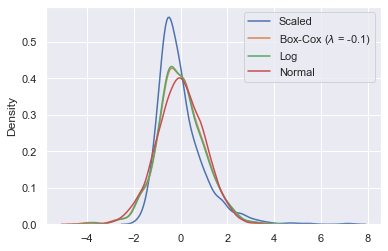

In [35]:
pt = PowerTransformer()
y = df_clean[[target_var]]
y2d = y.values
y1d = y2d[:,0]

y1 = (y1d - y1d.mean())/y1d.std(ddof=1)
pt.fit(y)
y2 = pt.transform(y2d)[:,0] 
y3 = np.log(y1d)
y3 = (y3-y3.mean())/y3.std(ddof=1)
y_norm = stats.norm.rvs(size=10000)

sns.kdeplot(y1.tolist(), label='Scaled')
sns.kdeplot(y2.tolist(), label=f'Box-Cox ($\lambda$ = {pt.lambdas_[0]:.1f})')
sns.kdeplot(y3.tolist(), label=f'Log')
sns.kdeplot(y_norm, label='Normal')
plt.legend()

## Feature engineering motivation

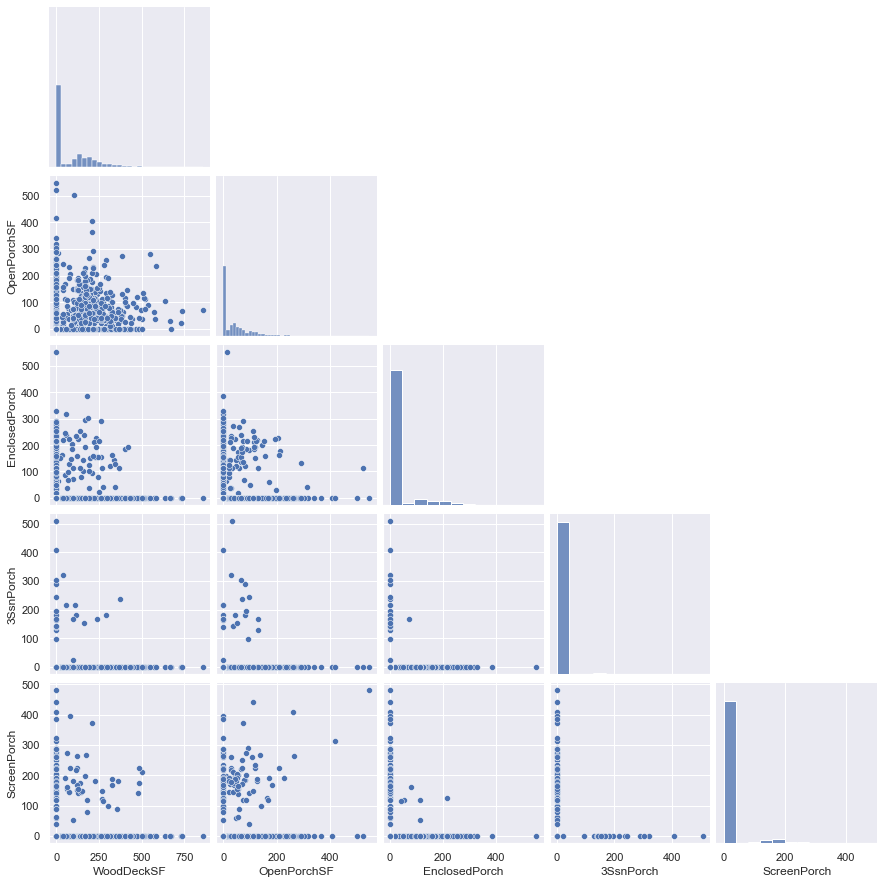

In [36]:
corr_check = ['WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
#corr_check = ['GarageCars','GarageArea']
#corr_check = ['YearBuilt','GarageYrBlt','YearRemodAdd']
#corr_check = ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath']
sns.pairplot(df_train[corr_check], corner=True, dropna=True)

## Check if all selected features are necessary

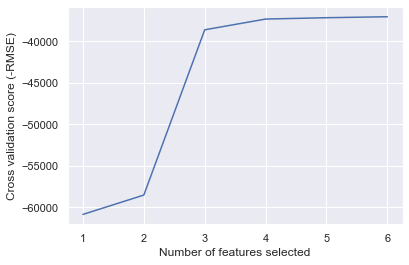

Optimal number of features : 6
Feature ranking:
	 0 - Rank  1) TotalSF
	 1 - Rank  1) BsmtUnfSF
	 2 - Rank  1) YearBuilt
	 3 - Rank  1) LotArea
	 4 - Rank  1) 2ndFlrSF
	 5 - Rank  1) GarageCars


In [117]:
X_train = df_clean[selected_num_cols]
y_train = df_clean['SalePrice']

estimator = LinearRegression(normalize=True)
# selector = SequentialFeatureSelection(estimator, 
#                                       n_features_to_select=0.99, 
#                                       scoring='neg_root_mean_squared_error')
selector = RFECV(estimator,
                 scoring='neg_root_mean_squared_error')

selector.fit(X_train, y_train)

#df_train = selector.transform(df_train)

# If RFECV is used
n_scores = len(selector.grid_scores_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (-RMSE)")
x_range = np.arange(len(selector.grid_scores_)) + 1
plt.plot(x_range, selector.grid_scores_)
plt.show()
print("Optimal number of features : %d" % selector.n_features_)

print("Feature ranking:")
for i, rank in sorted(enumerate(selector.ranking_), key=lambda x : x[1]):
    feature_name = X_train.iloc[:,i].name
    print(f'\t{i:2} - Rank {rank:2}) {feature_name}')

## Discretizing continuous distribution to assess homoscedasticity

,Strategy,nBins,W,pval,equal_var
11,quantile,10,23.902304,2.000521e-38,False
9,quantile,20,12.982134,5.423430e-38,False
4,kmeans,5,44.868825,1.447763e-35,False
8,quantile,5,37.170929,1.248150e-29,False
0,uniform,5,36.073591,8.922017e-29,False
3,uniform,10,17.742926,3.662330e-28,False
10,quantile,50,5.282206,2.990004e-27,False
7,kmeans,10,16.933067,8.498437e-27,False
1,uniform,20,9.221395,2.969614e-23,False
2,uniform,50,5.518092,5.191437e-23,False


quantile 10


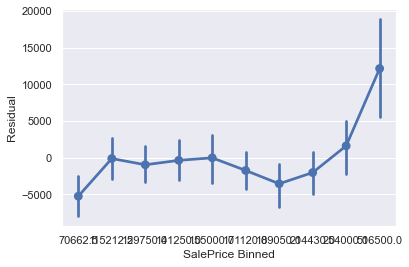

In [38]:
bin_strategy = ['uniform','kmeans','quantile']
n_bins = [5, 20, 50, 10]
results = []

for s in bin_strategy:
    for n in n_bins:
        est = KBinsDiscretizer(n_bins=n, encode='ordinal', strategy=s)
        target_binned = est.inverse_transform(est.fit_transform(X=df_pm[target_var].to_frame())).flatten()
        df_pm['SalePrice Binned'] = target_binned
        result = pg.homoscedasticity(data=df_pm, dv='Residual', group='SalePrice Binned')
        results.append([s, n] + result.values.tolist()[0])

results = pd.DataFrame(results, columns=['Strategy', 'nBins', 'W', 'pval', 'equal_var'])
display(results.sort_values('pval'))

print(s, n)
sns.pointplot(data=df_pm, x='SalePrice Binned', y='Residual')